# Imports

In [2]:
from kan import KAN, LBFGS
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import time

In [3]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [4]:
def loss_fun(t_int,x_int,t_bc,x_bc,t_ic,x_ic, model):
    input_tensor = torch.cat((t_int, x_int), dim=1)
    u = model(input_tensor)
    u_t = torch.autograd.grad(
            u, t_int,
            grad_outputs=torch.ones_like(t_int),
            create_graph=True)[0]
    u_x = torch.autograd.grad(
            u, x_int,
            grad_outputs=torch.ones_like(x_int),
            create_graph=True)[0]
    u_xx = torch.autograd.grad(
            u_x, x_int,
            grad_outputs=torch.ones_like(x_int),
            create_graph=True)[0]
    R_int = torch.mean(torch.square(u_t + u * u_x - (0.01/torch.pi) * u_xx))
    
    input_tensor = torch.cat((t_bc,x_bc), dim=1)
    u_bc = model(input_tensor)
    R_bc  = torch.mean(torch.square(u_bc))
    
    input_tensor = torch.cat((t_ic,x_ic), dim=1)
    u_ic = model(input_tensor)
    R_ic  = torch.mean(torch.square(u_ic + torch.sin(x_train * torch.pi )))

    return R_int,R_bc,R_ic

In [5]:
# Interior points
sampling_mode = 'mesh'  # 'random' or 'mesh'

N              = 100
t_train        = torch.linspace(0, 0.5, N, requires_grad=True).reshape(N,1)
x_train        = torch.linspace(-1, 1, N, requires_grad=True).reshape(N,1)


if sampling_mode == 'mesh':
    # Generate interior t,x
    t_int, x_int = torch.meshgrid(t_train[1:].squeeze(), x_train[1:-1].squeeze())
    t_int = t_int.reshape(-1, 1)
    x_int = x_int.reshape(-1, 1)
else:
    pass

# Generate boundary t,x
t_bc,x_bc = torch.meshgrid(t_train.squeeze(), torch.cat((x_train[:1], x_train[-1:]), dim=0).squeeze())
t_bc = t_bc.reshape(-1, 1)
x_bc = x_bc.reshape(-1, 1)
# Generate initial t,x
t_ic,x_ic = torch.meshgrid(t_train[:1].squeeze(), x_train.squeeze())
t_ic = t_ic.reshape(-1, 1)
x_ic = x_ic.reshape(-1, 1)

c:\Users\shoun\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
lambda_b       = 10.0
lambda_ic      =10.0

steps = 20
alpha = 0.1
log = 1

global loss_int_hist, loss_bc_hist, loss_ic_hist, pred_hist

pred_hist      = np.zeros(N)

model = KAN(width=[2, 3, 3, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

In [7]:
def train(steps):

    loss_int_hist  = np.zeros(steps)
    loss_bc_hist    = np.zeros(steps)
    loss_ic_hist    = np.zeros(steps)
    
    pbar = tqdm(range(steps), desc='description')
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

    for epoch in pbar:
        def closure():
            global loss_int, loss_bc, loss_ic

            # zero the gradient buffers
            optimizer.zero_grad()
            # compute losses
            loss_int,loss_bc,loss_ic = loss_fun(t_int,x_int,t_bc,x_bc,t_ic,x_ic, model)
            loss = loss_int + lambda_b*loss_bc + lambda_ic*loss_ic
            # compute gradients of training loss
            loss.backward()
            
            return loss

        input_tensor = torch.cat((t_int, x_int), dim=1)
        if epoch % 5 == 0 and epoch < 50:
            model.update_grid_from_samples(input_tensor)

        optimizer.step(closure)
        loss = loss_int + lambda_b*loss_bc + lambda_ic*loss_ic

        if epoch % log == 0:
            pbar.set_description("interior pde loss: %.2e | bc loss: %.2e | ic loss: %.2e " % (loss_int.cpu().detach().numpy(), loss_bc.cpu().detach().numpy(), loss_ic.detach().numpy()))

        # print(f'   --- epoch {epoch+1}: loss_int = {loss_int.item():.4e}, loss_bc = {loss_bc.item():.4e}, loss_ic = {loss_ic.item():.4e}')
        
        # save loss
        loss_int_hist[epoch] = loss_int
        loss_bc_hist[epoch] = loss_bc
        loss_ic_hist[epoch] = loss_ic

In [7]:
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

interior pde loss: 4.25e-02 | bc loss: 2.25e-05 | ic loss: 1.56e-03 : 100%|██████████| 20/20 [11:22<00:00, 34.11s/it]

Training completed in 682.27 seconds.


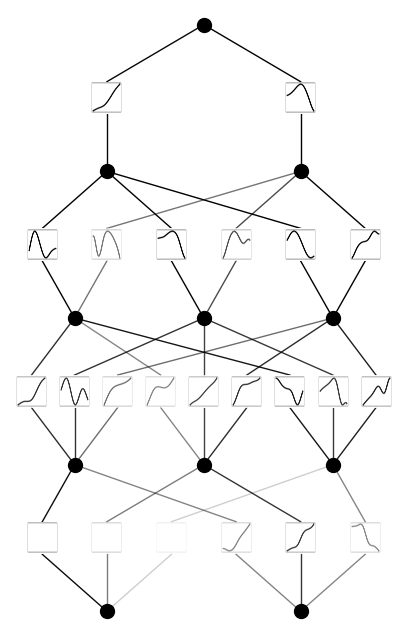

In [8]:
model.plot(beta=10)

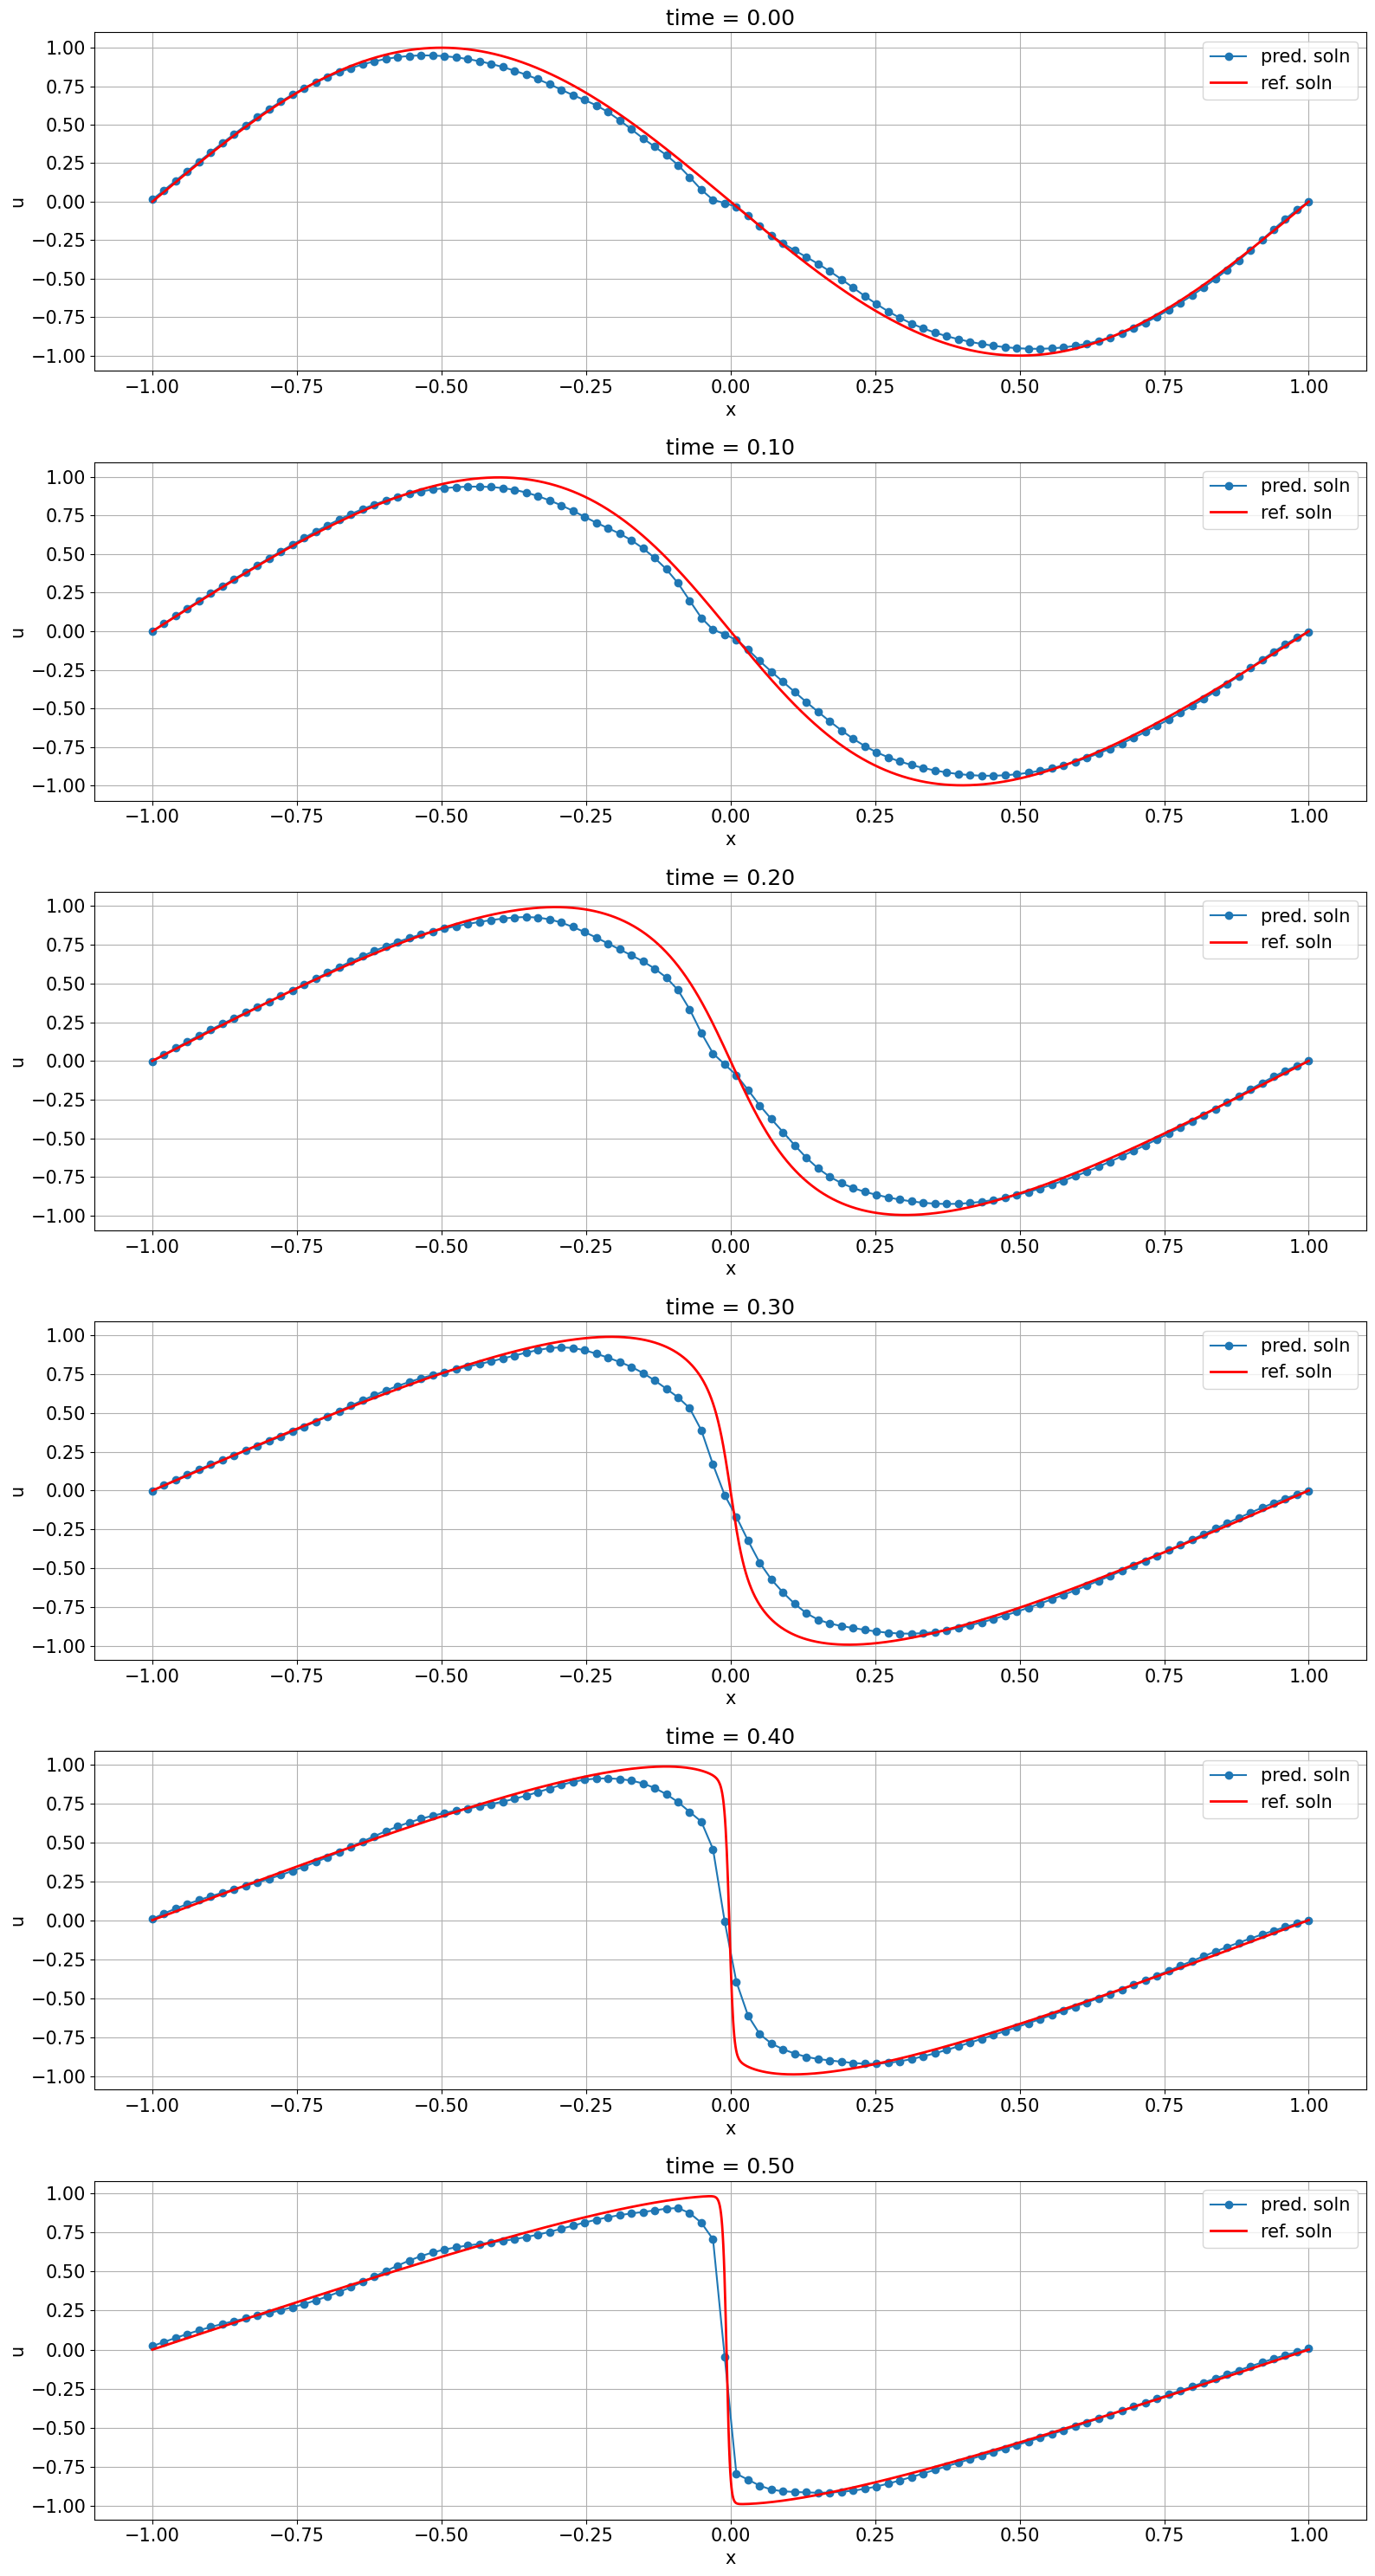

In [10]:
# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

interior pde loss: 1.51e-01 | bc loss: 1.76e-04 | ic loss: 5.06e-03 : 100%|██████████| 20/20 [03:46<00:00, 11.33s/it]


Training completed in 226.70 seconds.


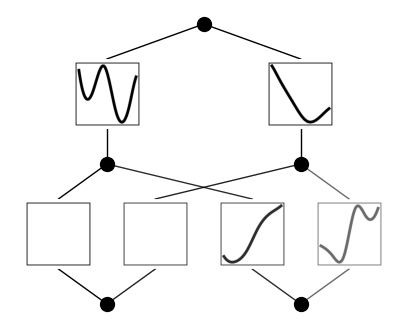

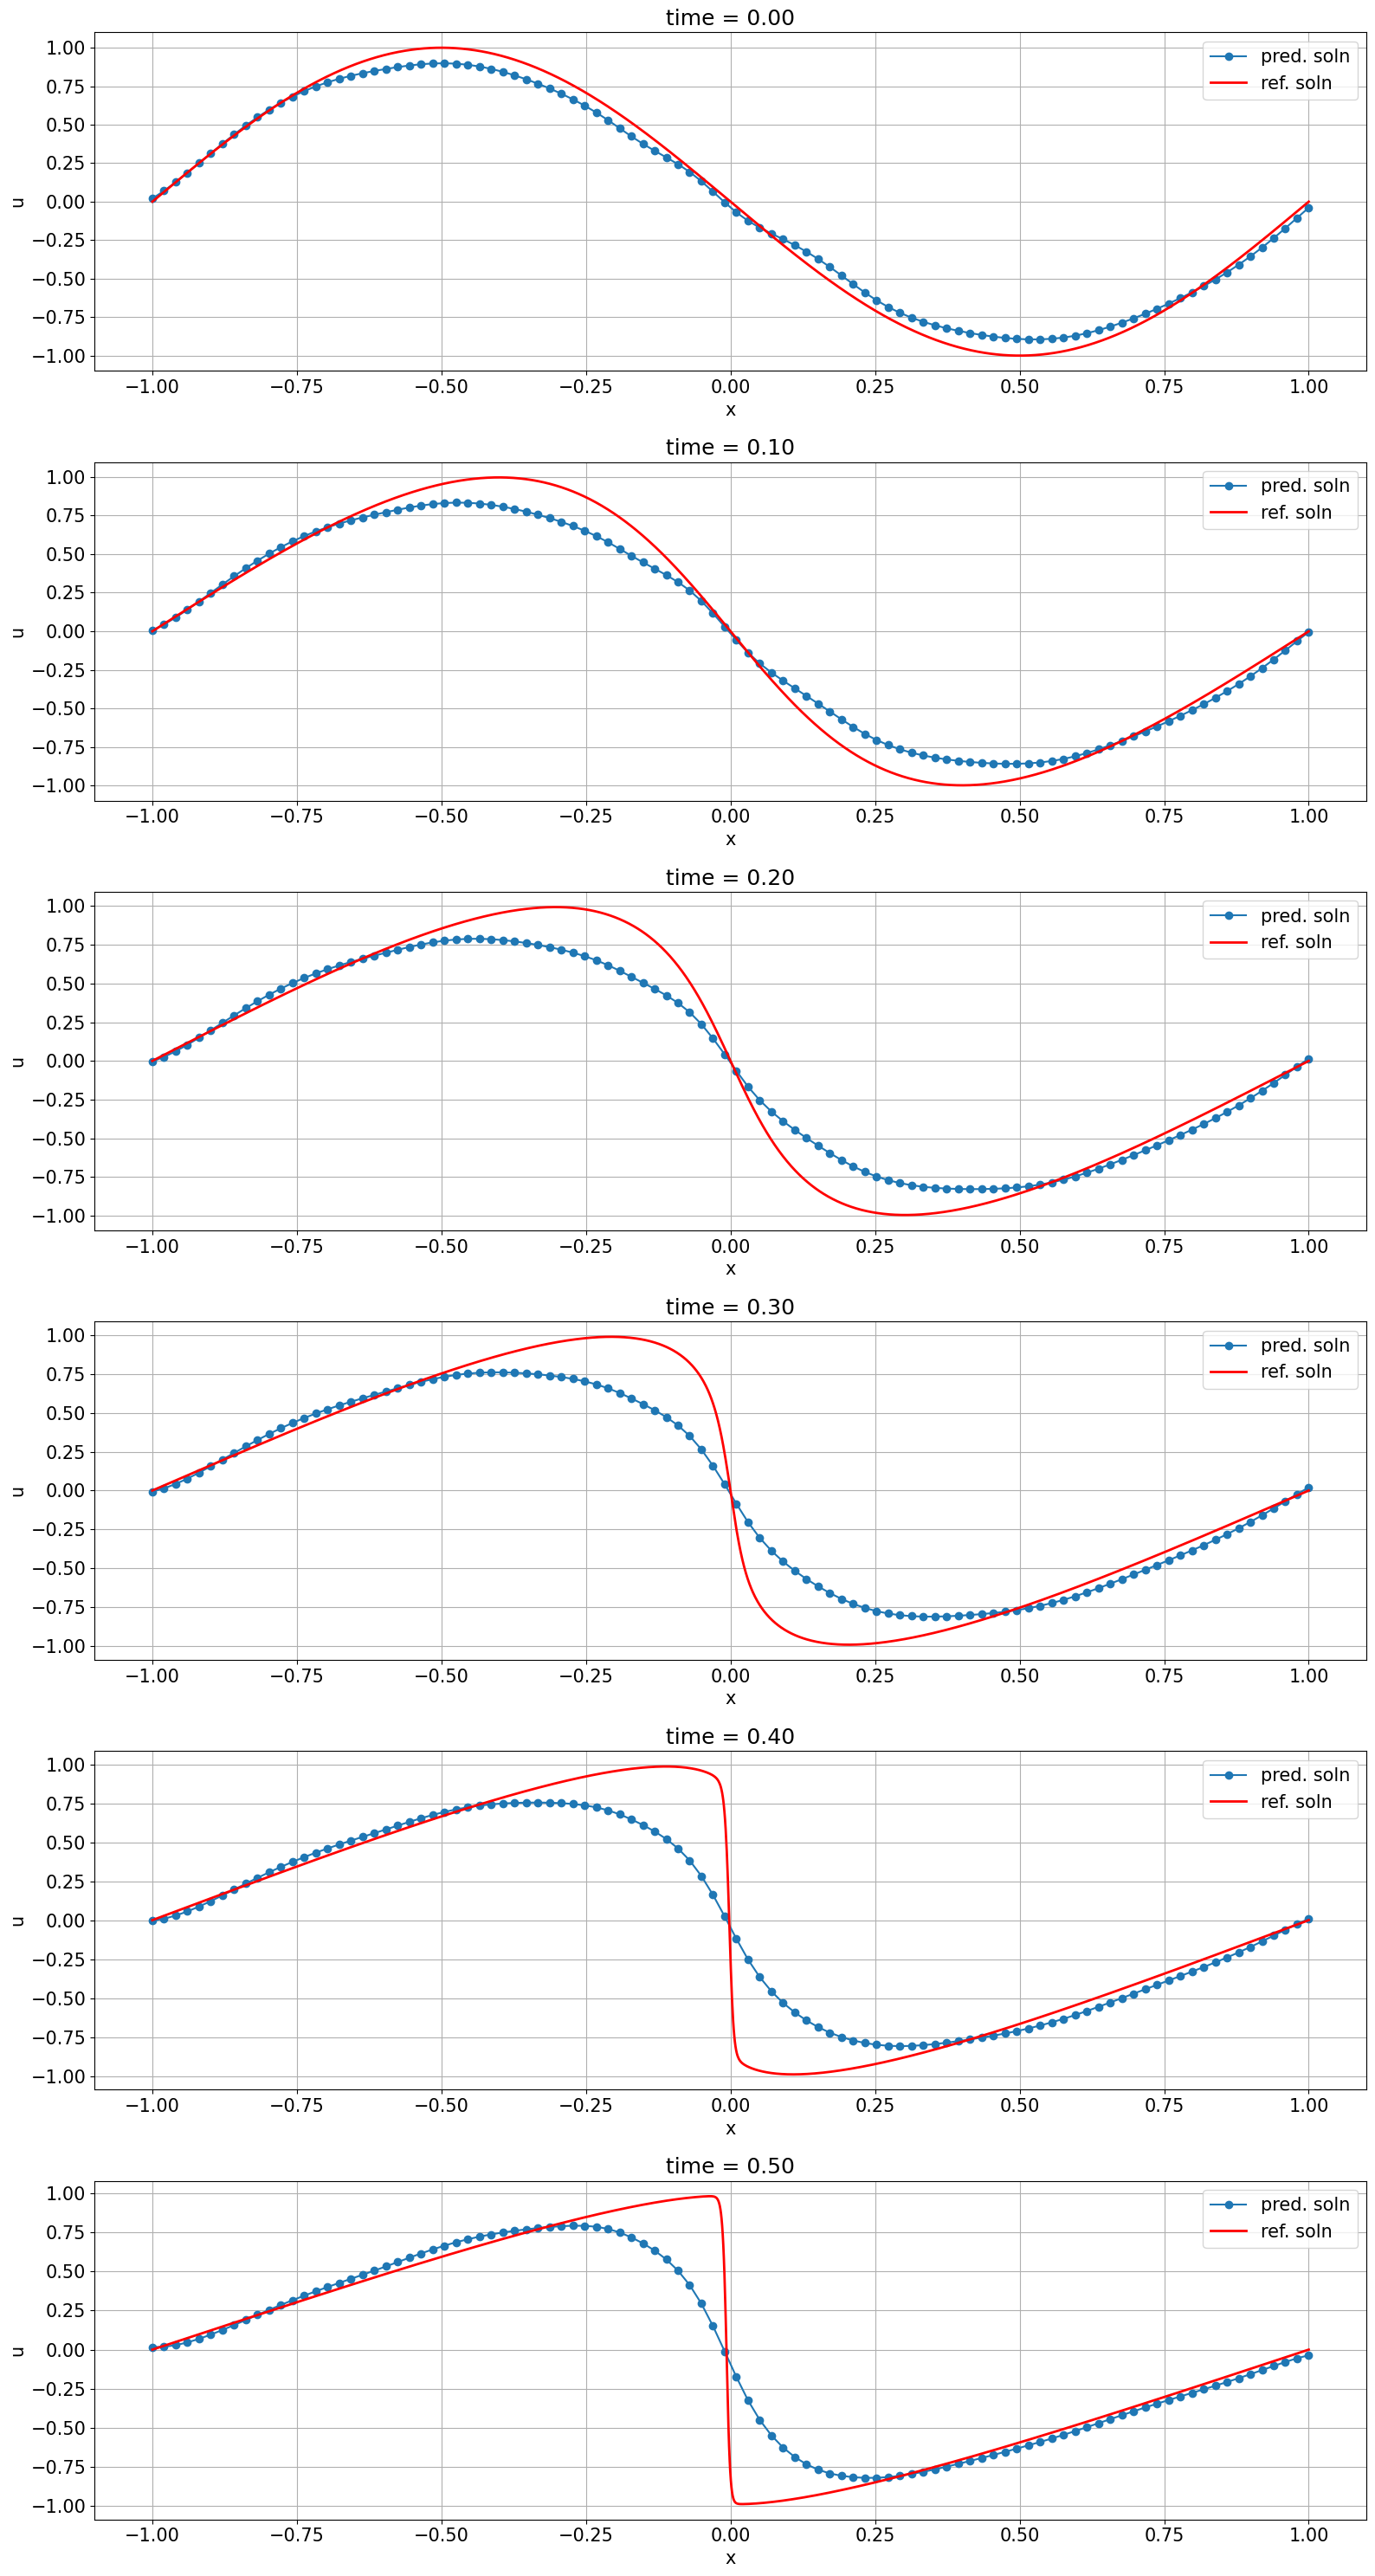

In [12]:
model = KAN(width=[2, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

steps =20

# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

interior pde loss: 3.60e-03 | bc loss: 3.22e-06 | ic loss: 1.30e-04 : 100%|██████████| 20/20 [1:38:47<00:00, 296.40s/it]


Training completed in 5927.97 seconds.


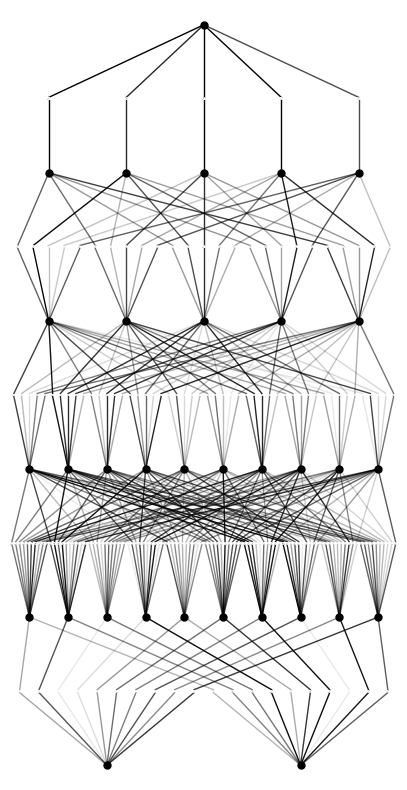

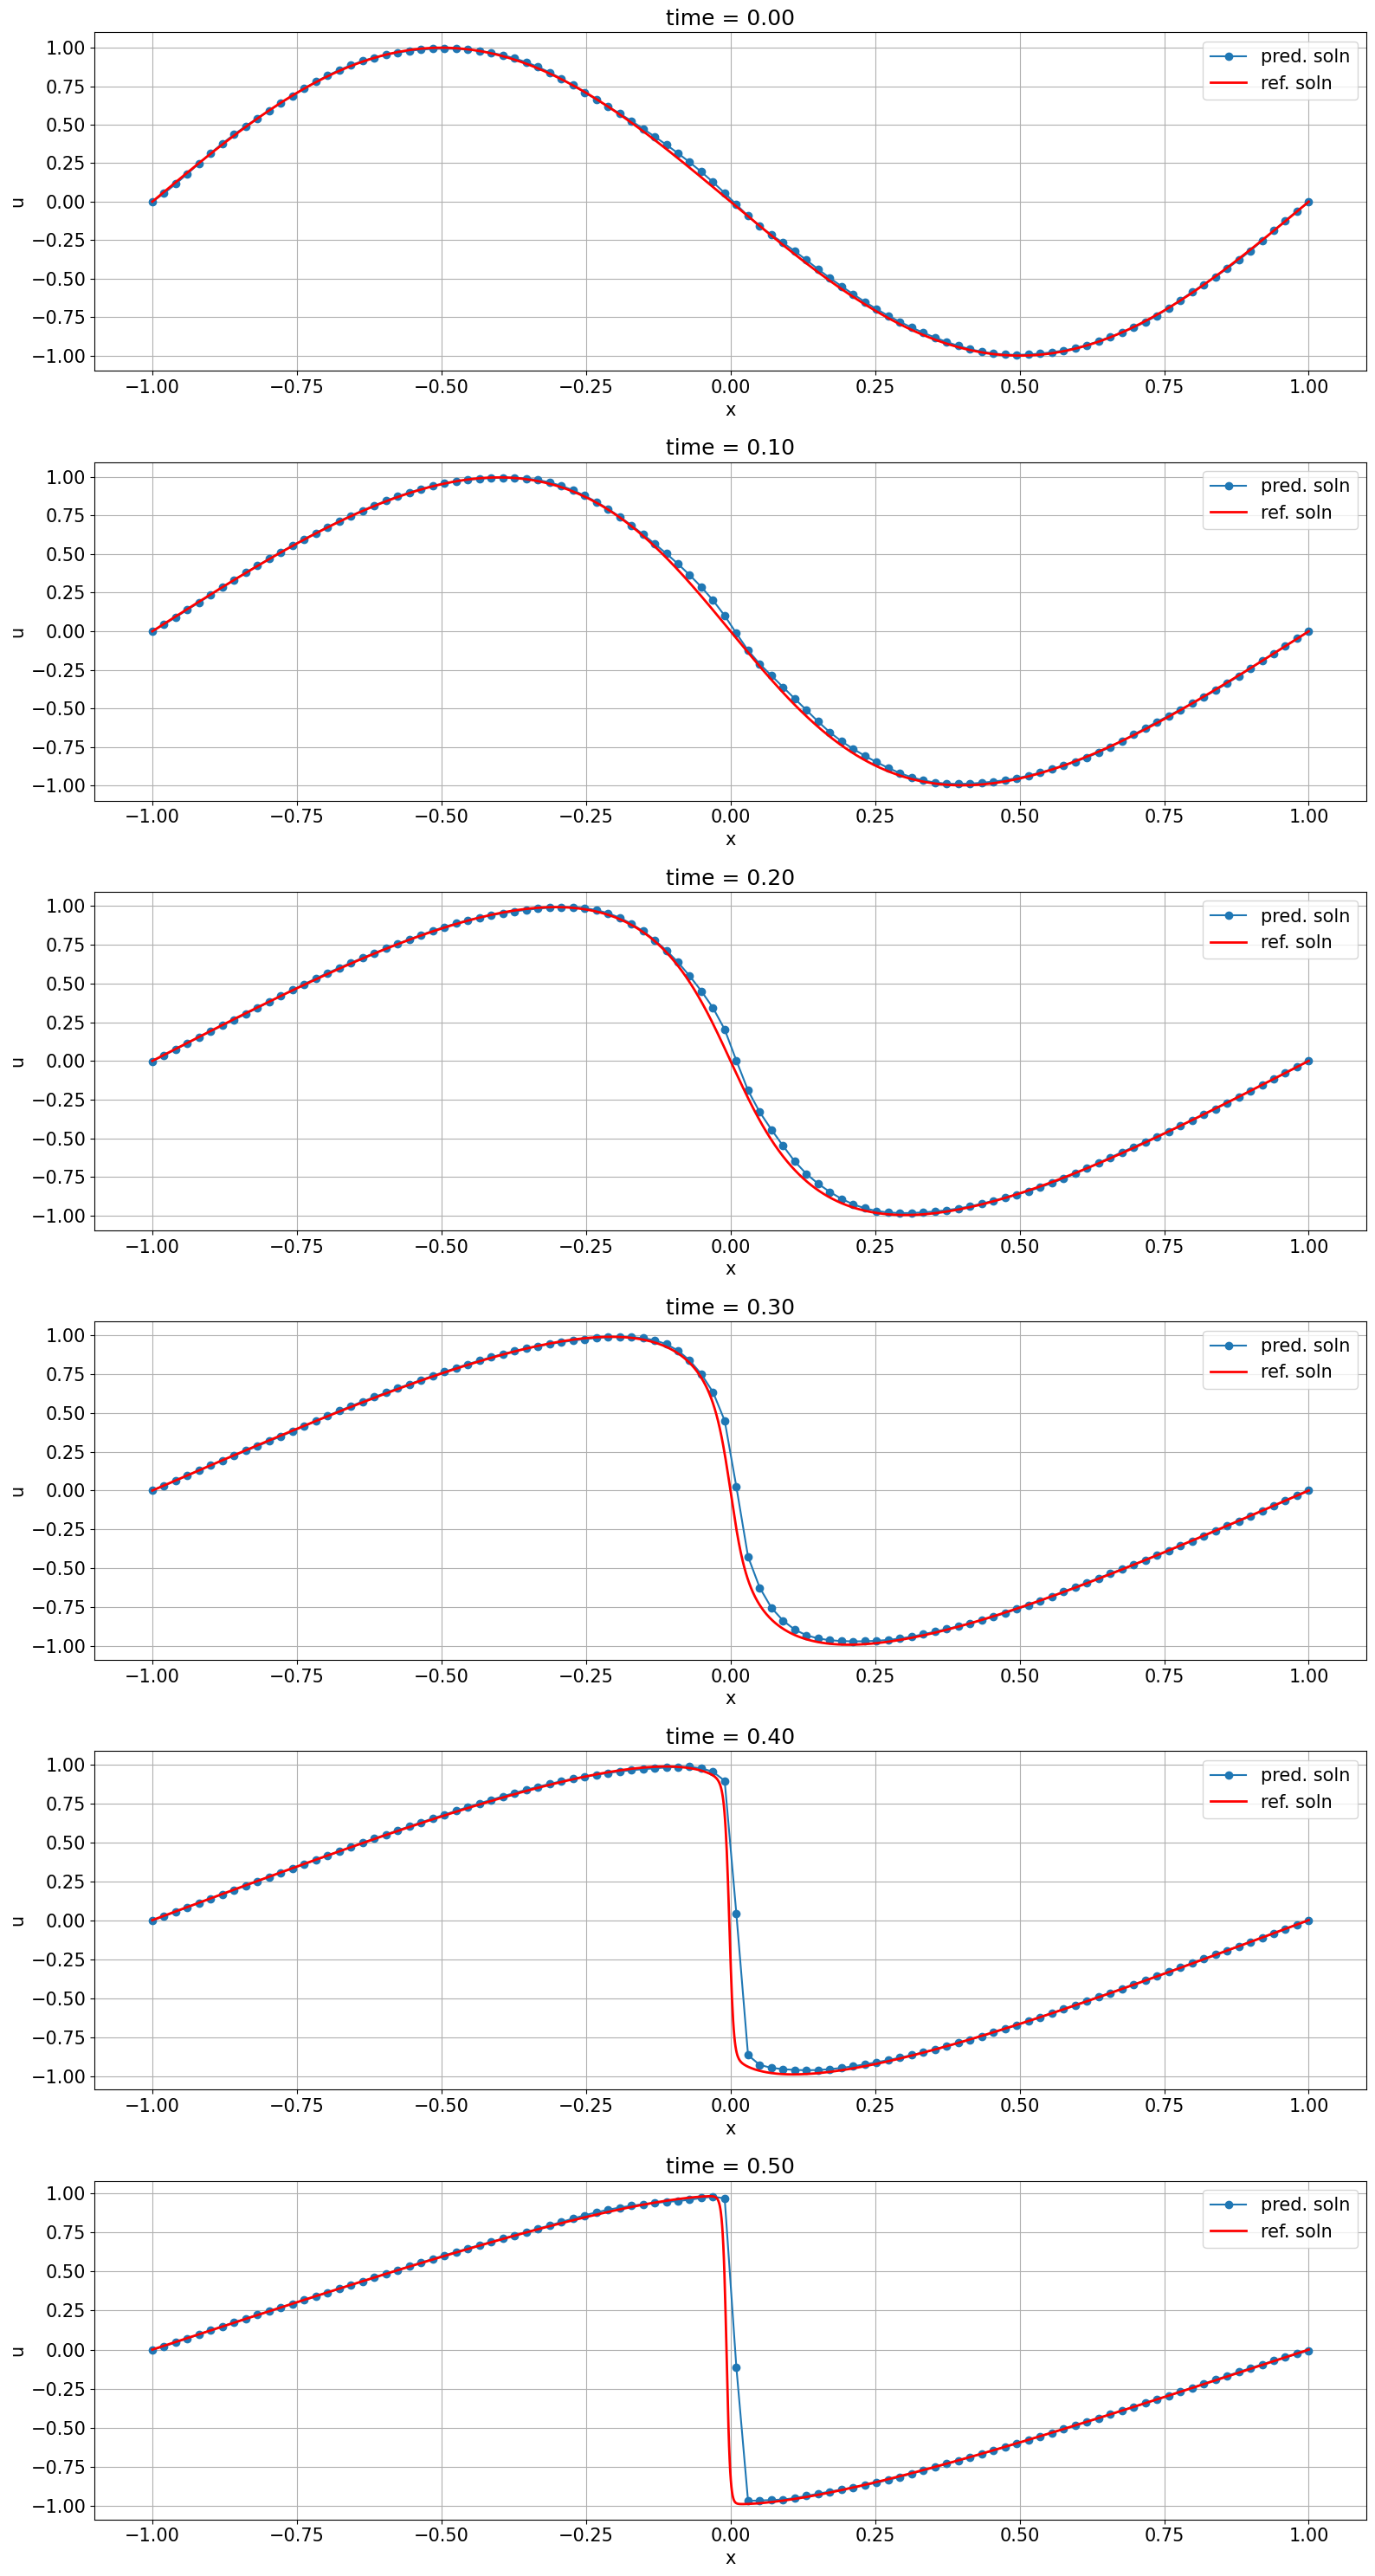

In [13]:
model = KAN(width=[2, 10, 10, 5, 5,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

steps =20

# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

# Adam Optimizer

interior pde loss: 1.07e-02 | bc loss: 2.09e-04 | ic loss: 4.73e-01 : 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Training completed in 83.04 seconds.


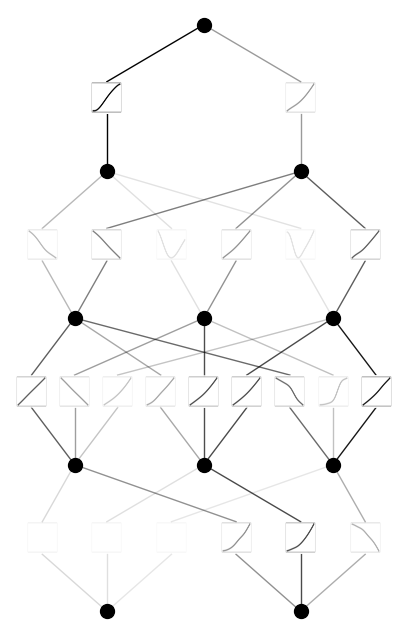

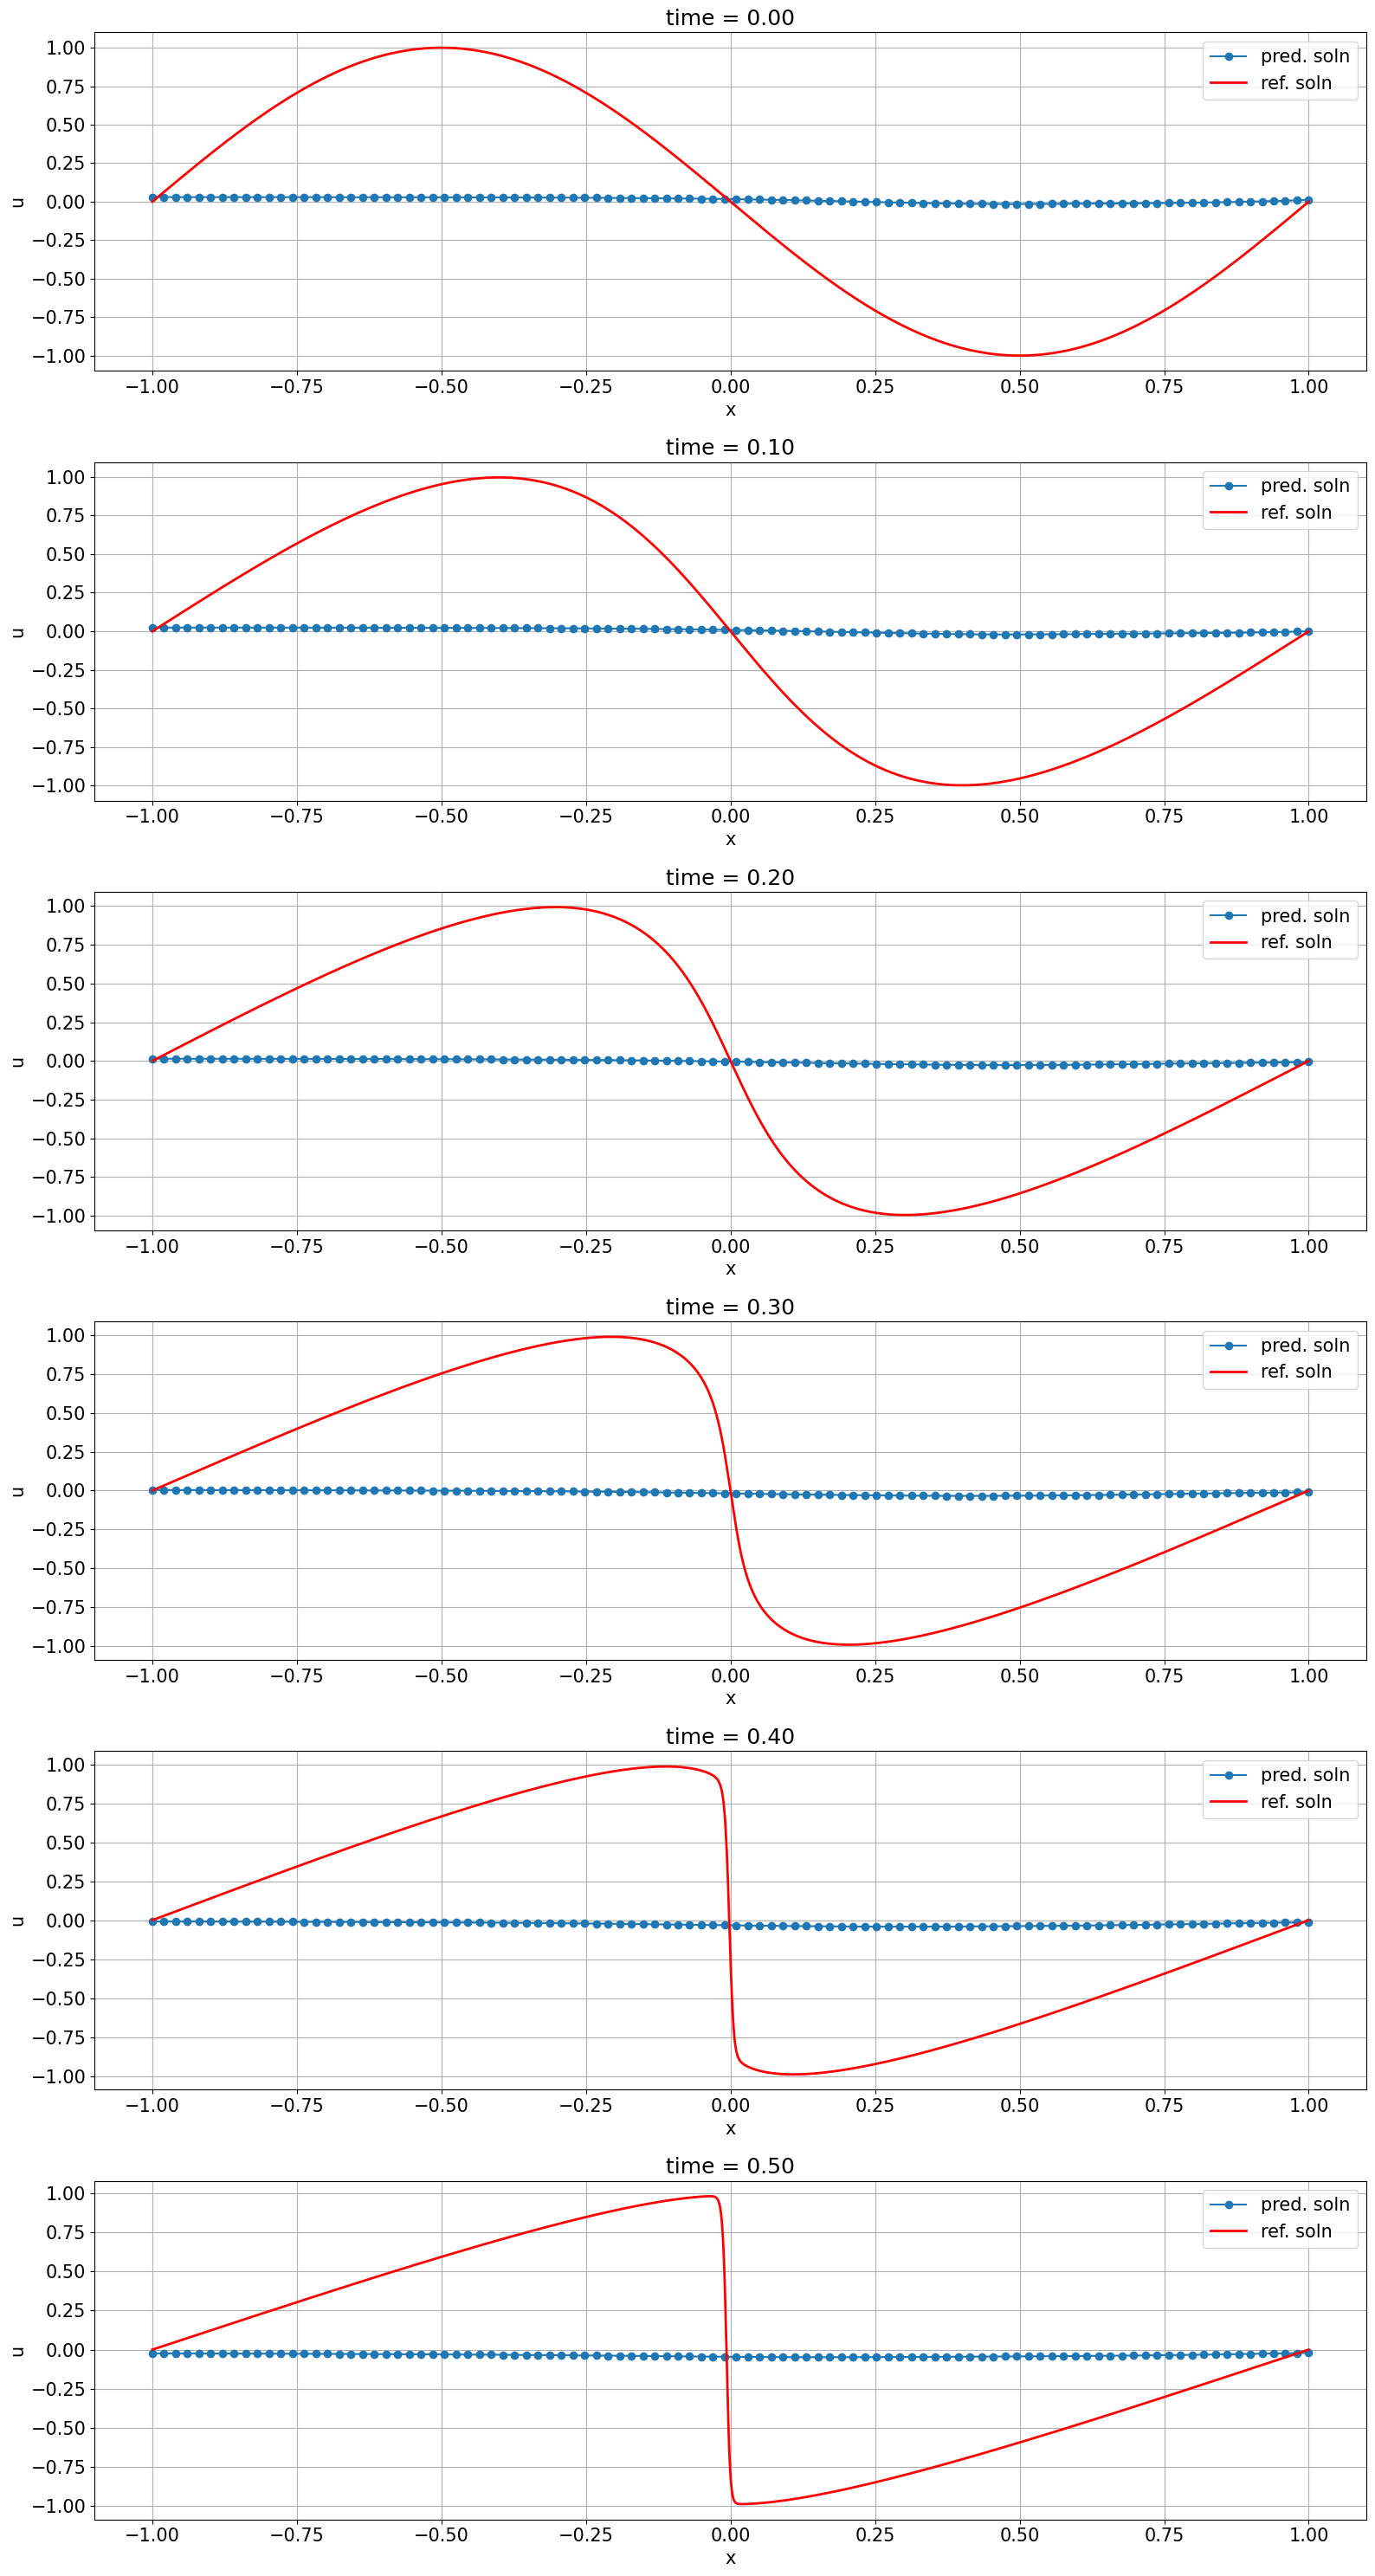

In [15]:
model = KAN(width=[2, 3, 3, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

description:   0%|          | 0/100 [00:00<?, ?it/s]

interior pde loss: 1.81e-02 | bc loss: 9.05e-02 | ic loss: 6.60e-01 : 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Training completed in 50.80 seconds.
Best value at boundary.
r2 is 2.0194839173657902e-20
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 2.0194839173657902e-20
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.9981023073196411
r2 is 0.9998725652694702
r2 is 0.9983035922050476
r2 is 0.9995608329772949


interior pde loss: 2.85e-01 | bc loss: 1.32e-02 | ic loss: 3.63e-01 : 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Training completed in 65.48 seconds.
0.0947*sin(-3.50749*(-x_1 - 0.96262)**2 + 1.34882*(-0.8644*x_2 - 1)**2 + 4.90672) - 1.32754*sin(0.10418*(-x_1 - 0.95983)**2 - 0.07879*(-x_2 - 0.96398)**2 + 2.02349) + 1.20079


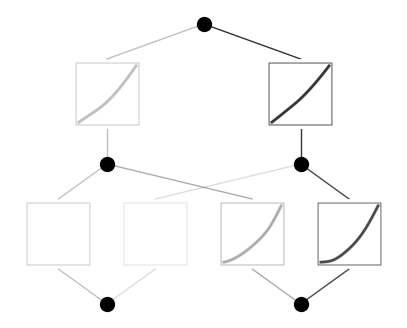

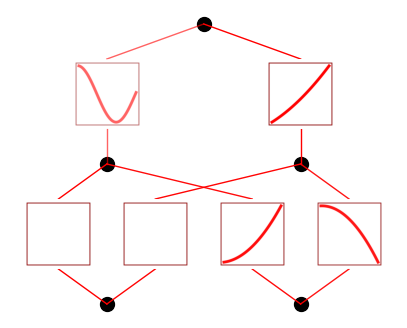

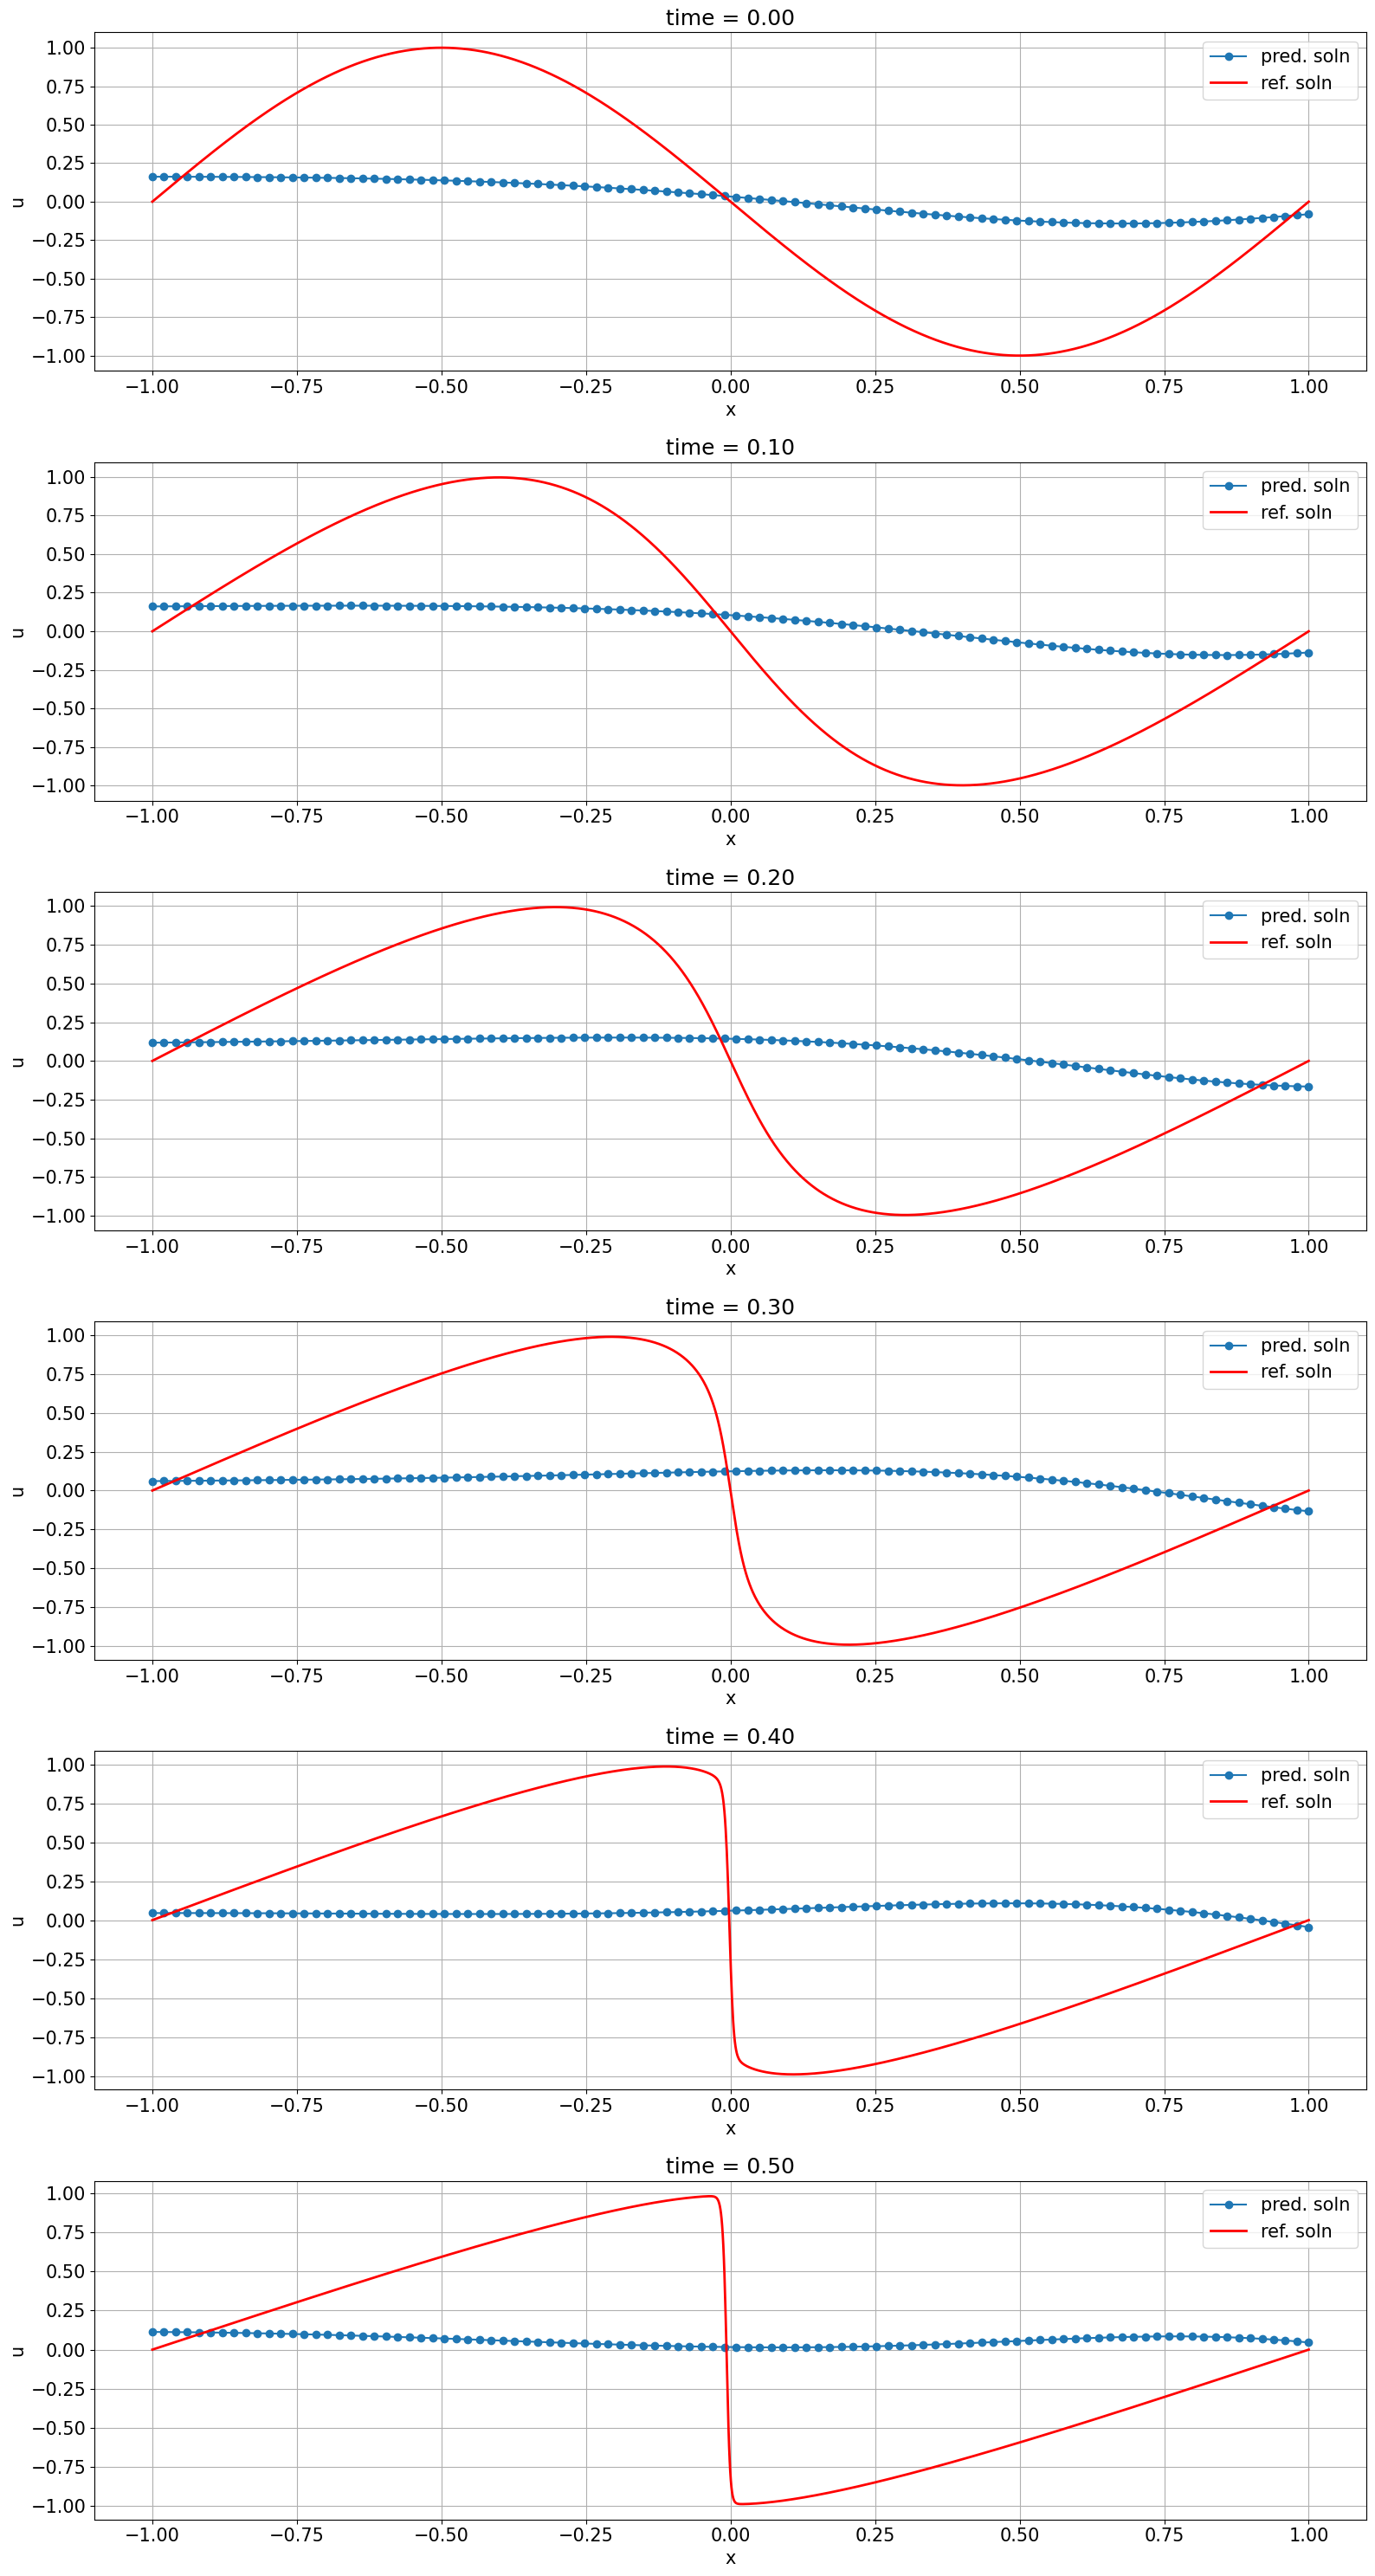

In [11]:
model = KAN(width=[2, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

steps = 100
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

for i in range(2):
    for j in range(2):
        model.fix_symbolic(0,i,j,'x^2')

for i in range(2):
    model.fix_symbolic(1,i,0,'sin')

start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

formula, var = model.symbolic_formula(floating_digit=5)
print(formula[0])

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

interior pde loss: 4.38e-02 | bc loss: 3.23e-03 | ic loss: 2.09e-01 : 100%|██████████| 2000/2000 [09:12<00:00,  3.62it/s]


Training completed in 552.88 seconds.


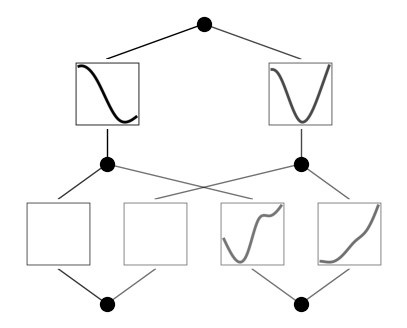

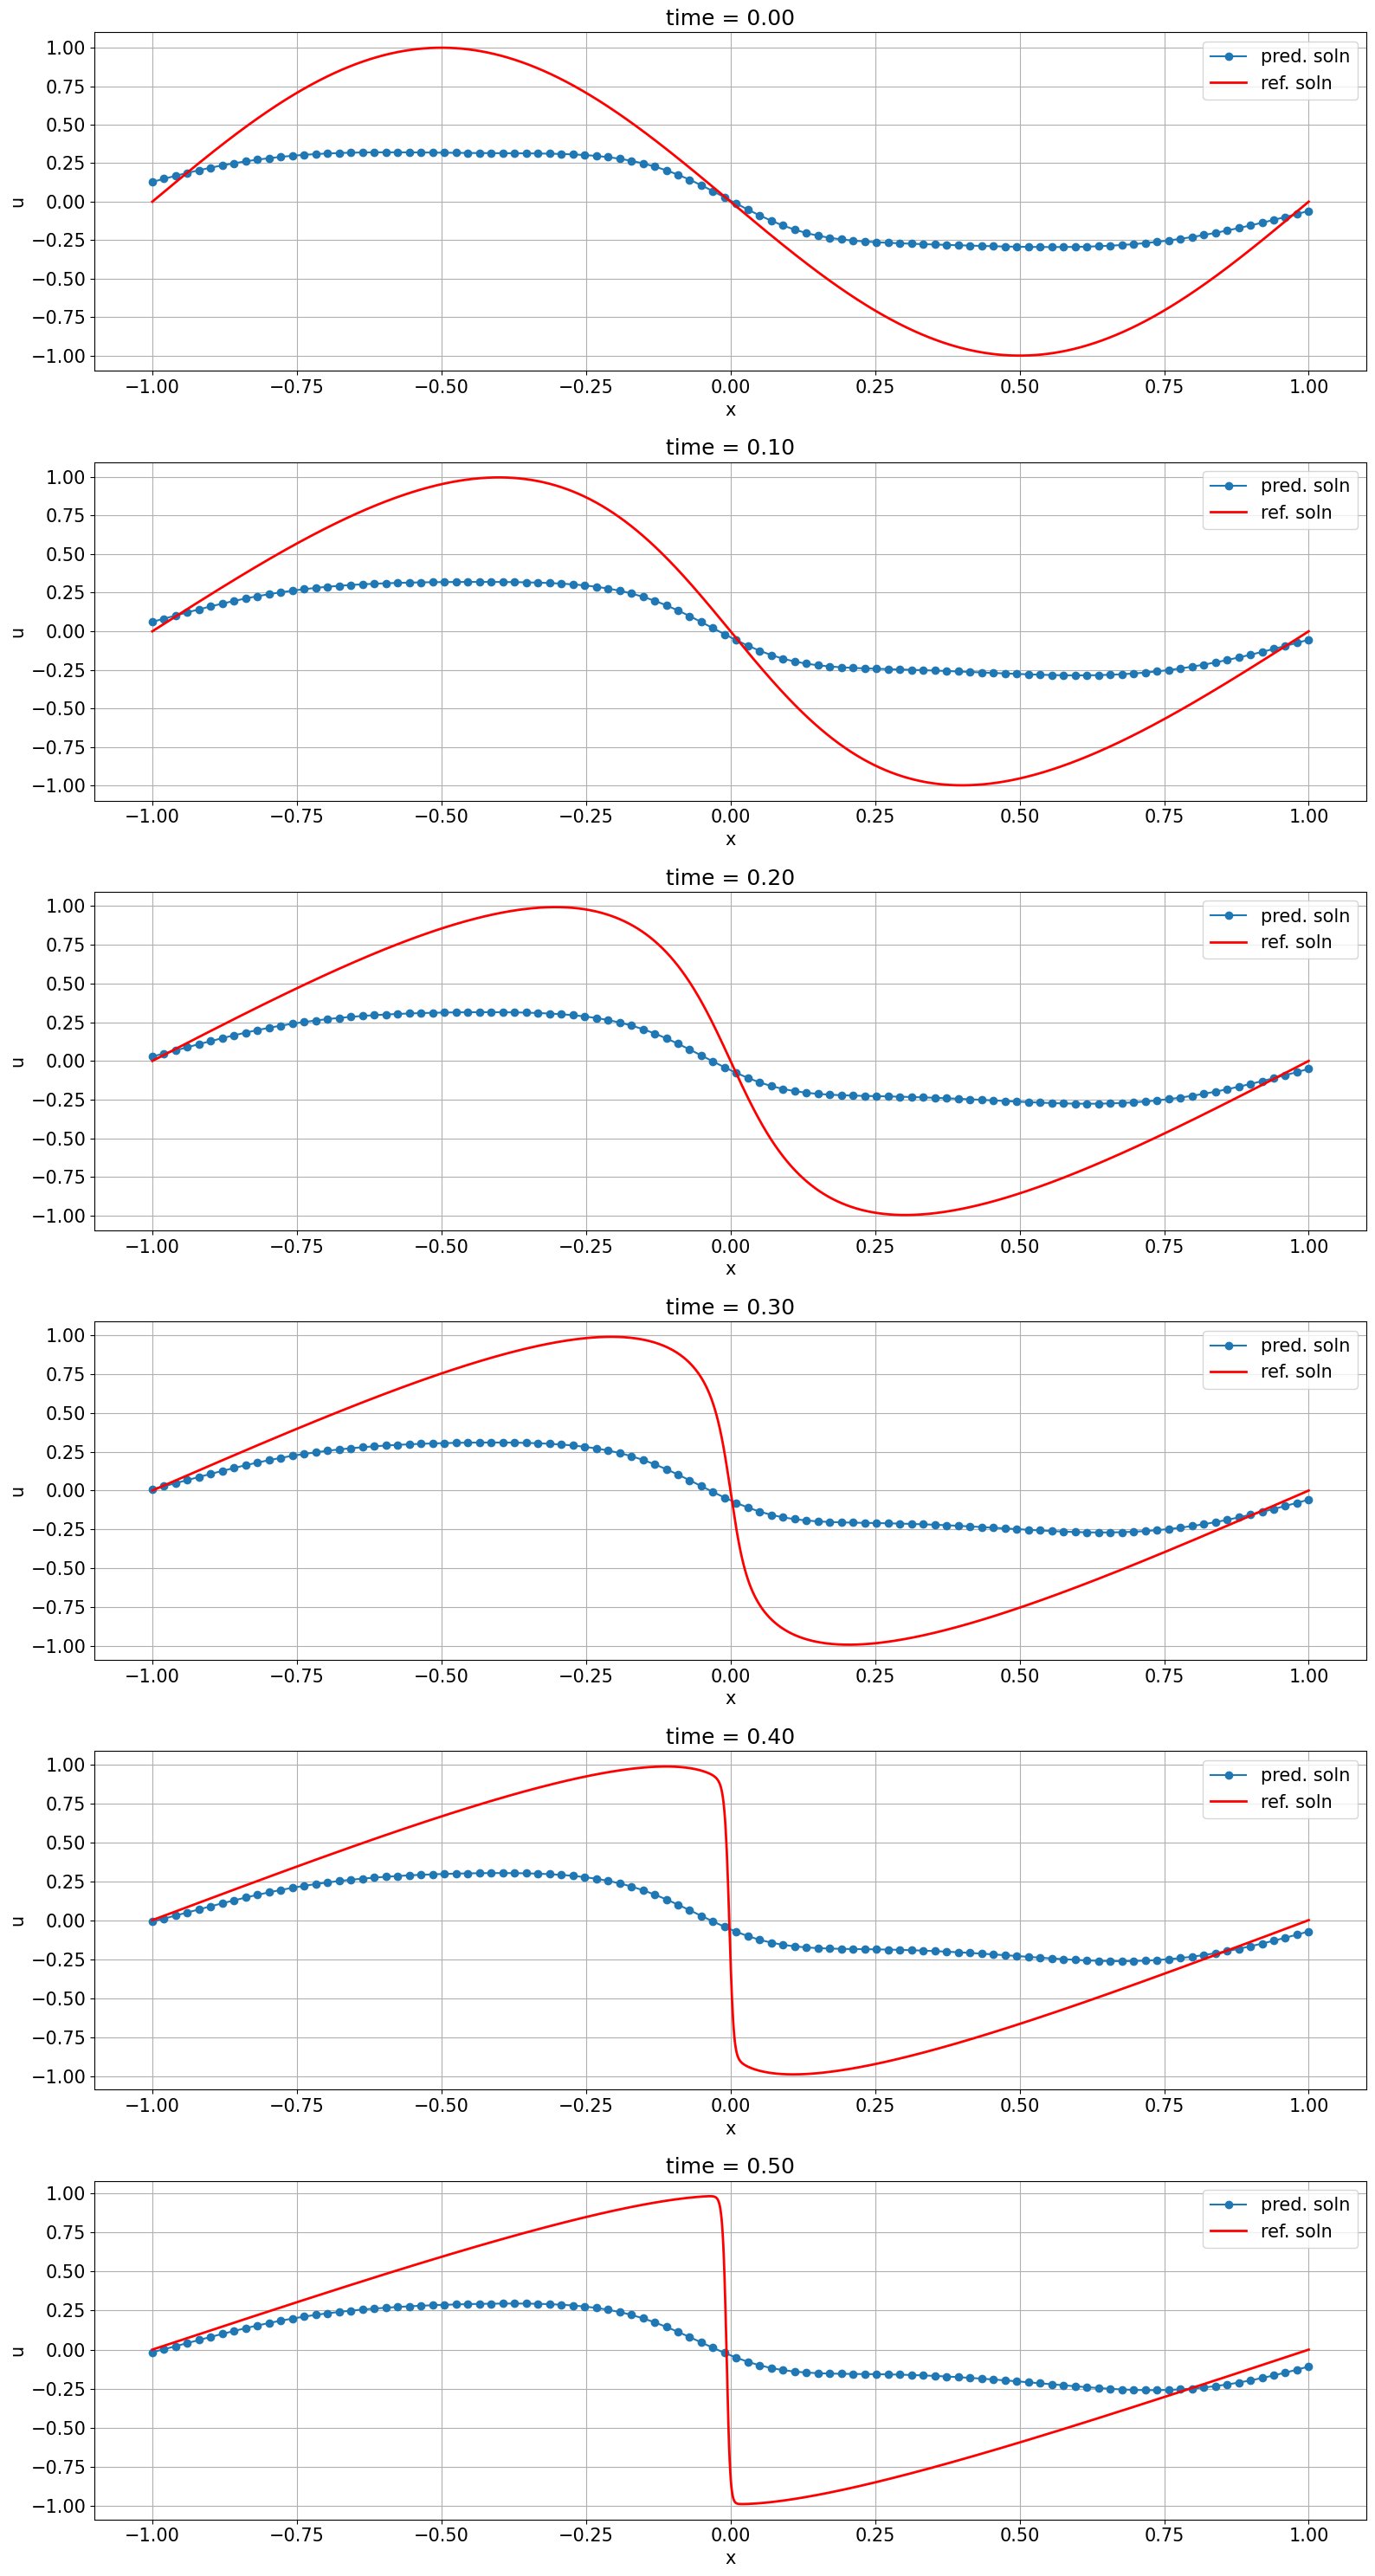

In [18]:
model = KAN(width=[2, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

steps = 2000
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

description:   0%|          | 0/2000 [00:00<?, ?it/s]

interior pde loss: 4.38e-02 | bc loss: 3.23e-03 | ic loss: 2.09e-01 : 100%|██████████| 2000/2000 [11:25<00:00,  2.92it/s]


Training completed in 685.36 seconds.
Best value at boundary.
r2 is 3.2311742677852644e-19
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 3.2311742677852644e-19
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.794886589050293
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.9925287961959839
Best value at boundary.
r2 is 0.9983212351799011
Best value at boundary.
r2 is 0.9806524515151978


interior pde loss: 2.80e-01 | bc loss: 1.17e-02 | ic loss: 7.30e-02 : 100%|██████████| 2000/2000 [09:33<00:00,  3.49it/s]


Training completed in 573.57 seconds.
-0.31169*sin(0.61648*(-x_1 - 0.98334)**2 - 1.21598*(-0.93921*x_2 - 1)**2 + 4.7706) + 0.48196*sin(0.08025*(-x_1 - 0.94697)**2 + 2.62323*(-0.72237*x_2 - 1)**2 - 6.14282) - 0.24243


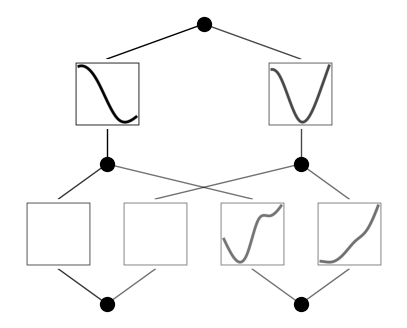

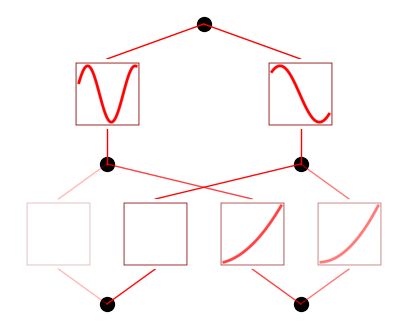

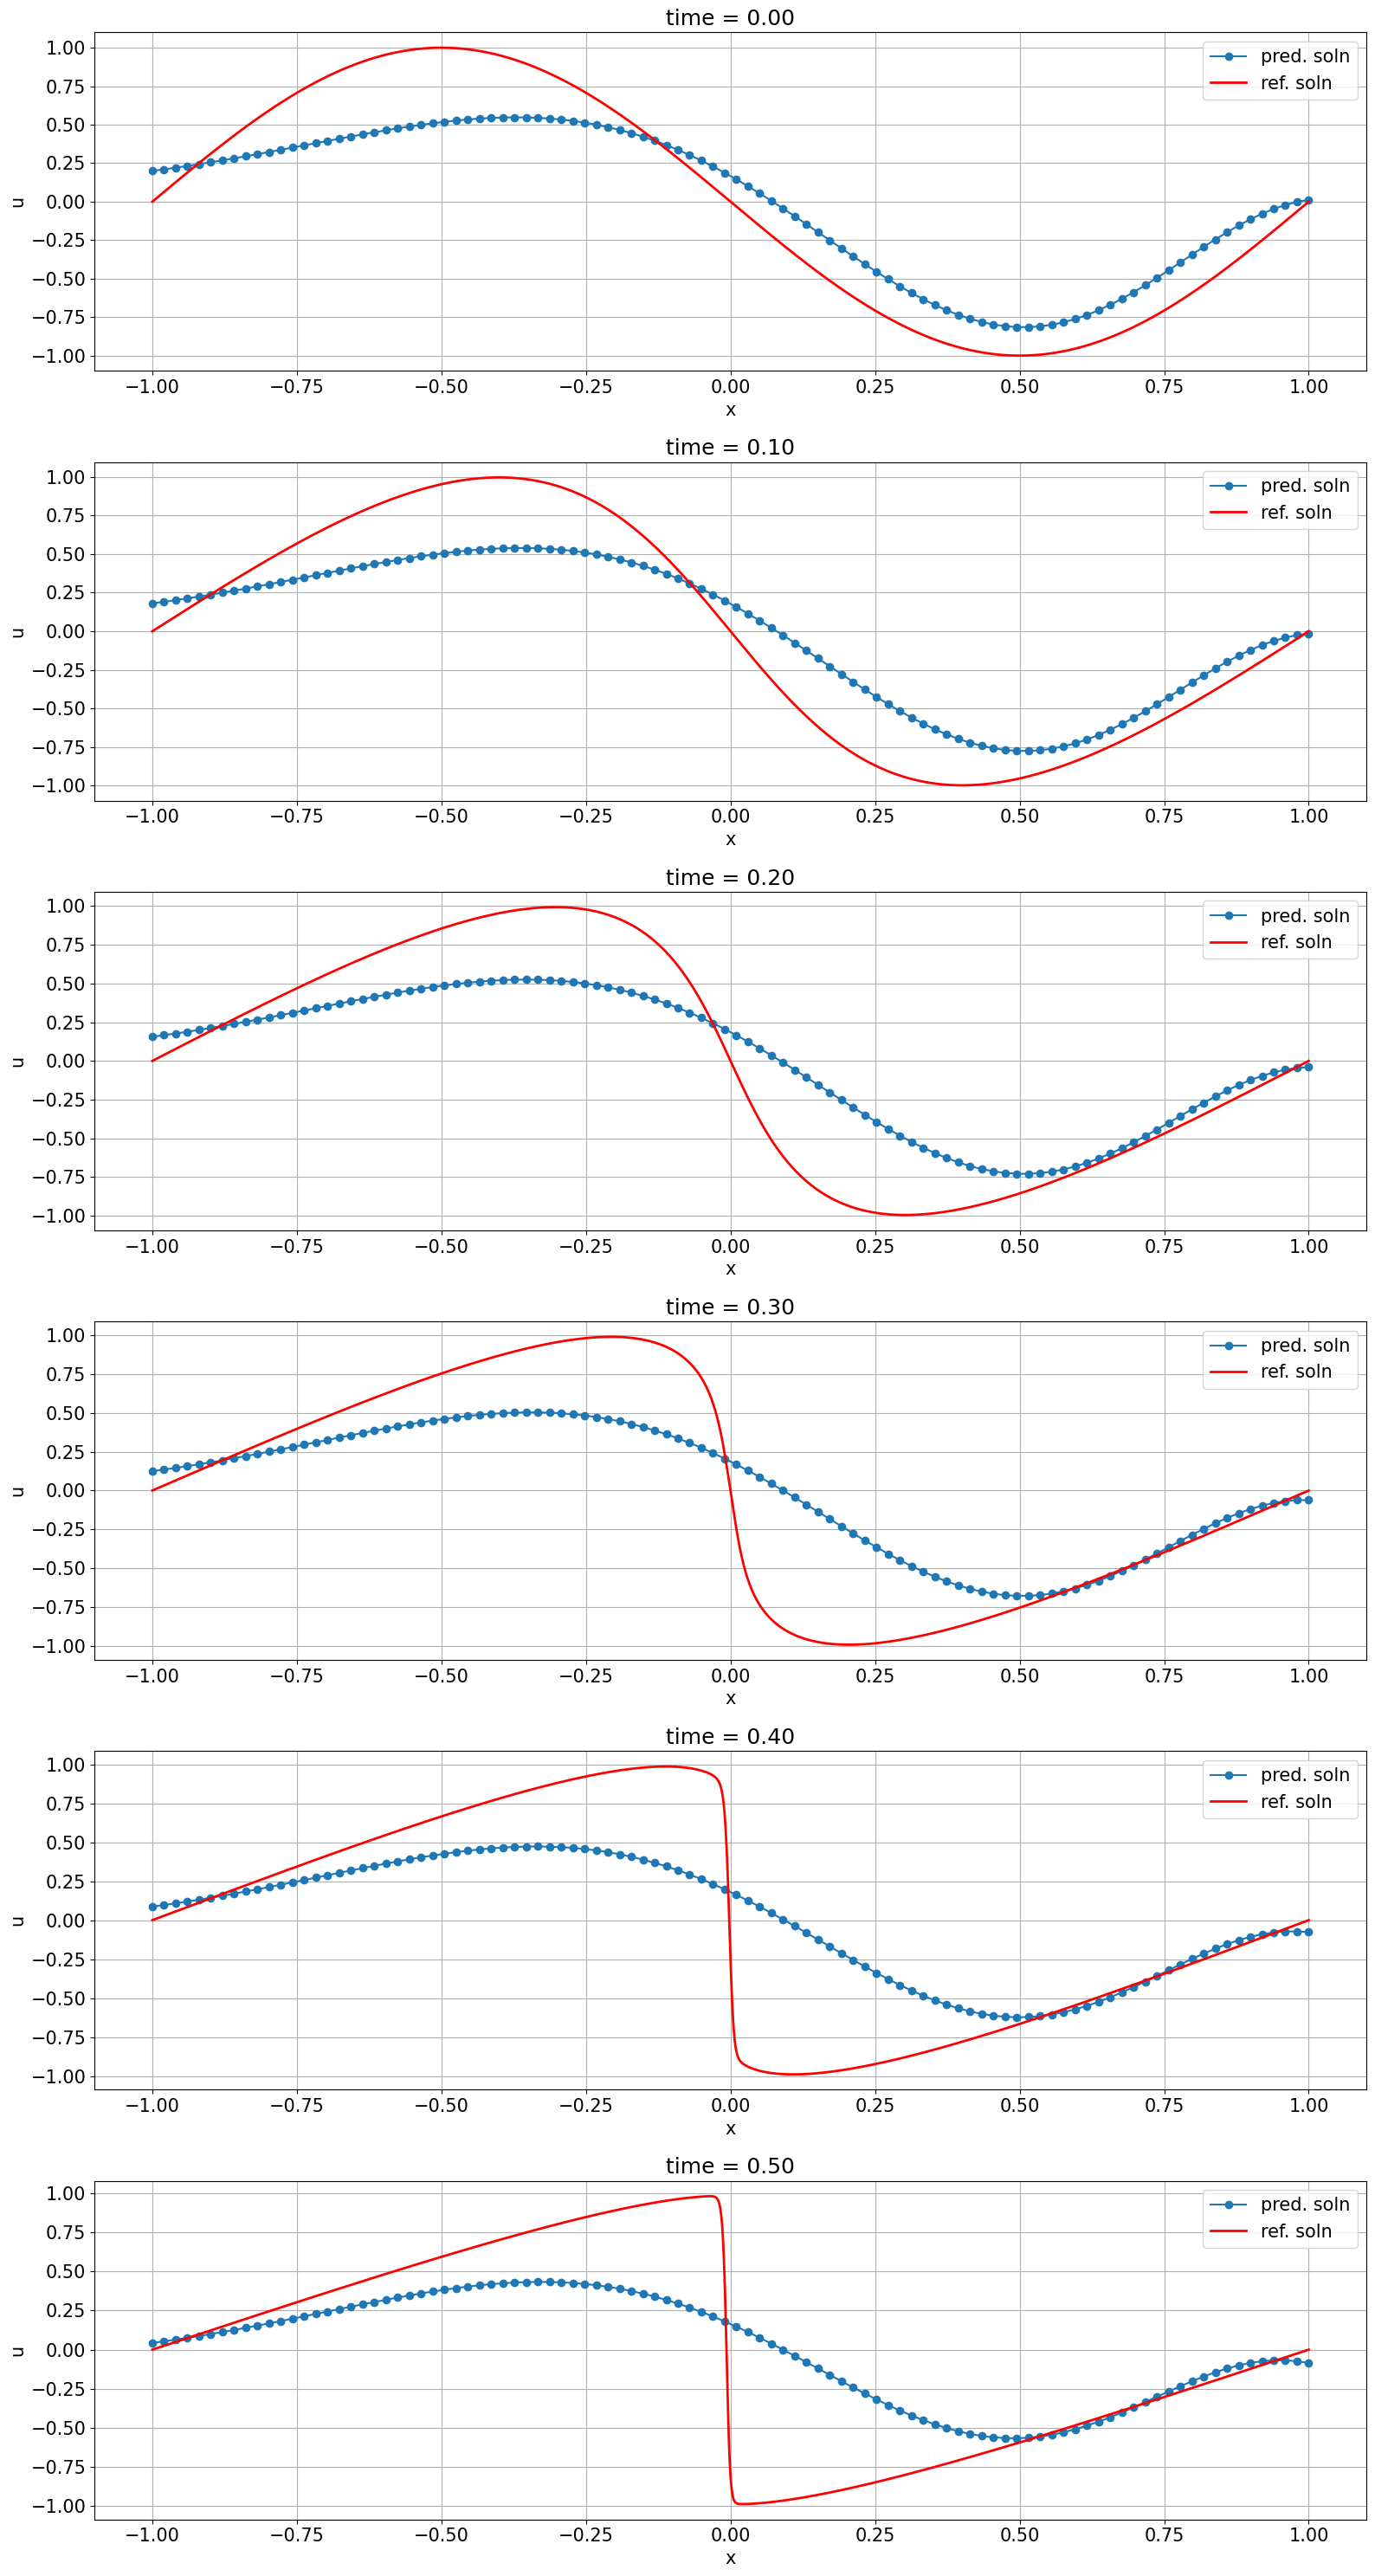

In [15]:
model = KAN(width=[2, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

steps = 2000
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

for i in range(2):
    for j in range(2):
        model.fix_symbolic(0,i,j,'x^2')

for i in range(2):
    model.fix_symbolic(1,i,0,'sin')

start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

formula, var = model.symbolic_formula(floating_digit=5)
print(formula[0])

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

description:   0%|          | 0/20 [00:00<?, ?it/s]

interior pde loss: 2.71e-02 | bc loss: 9.65e-03 | ic loss: 4.02e-01 : 100%|██████████| 20/20 [02:53<00:00,  8.68s/it]


Training completed in 173.53 seconds.


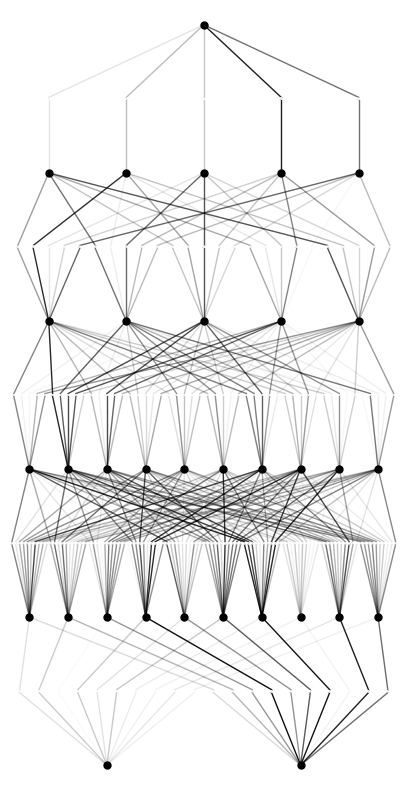

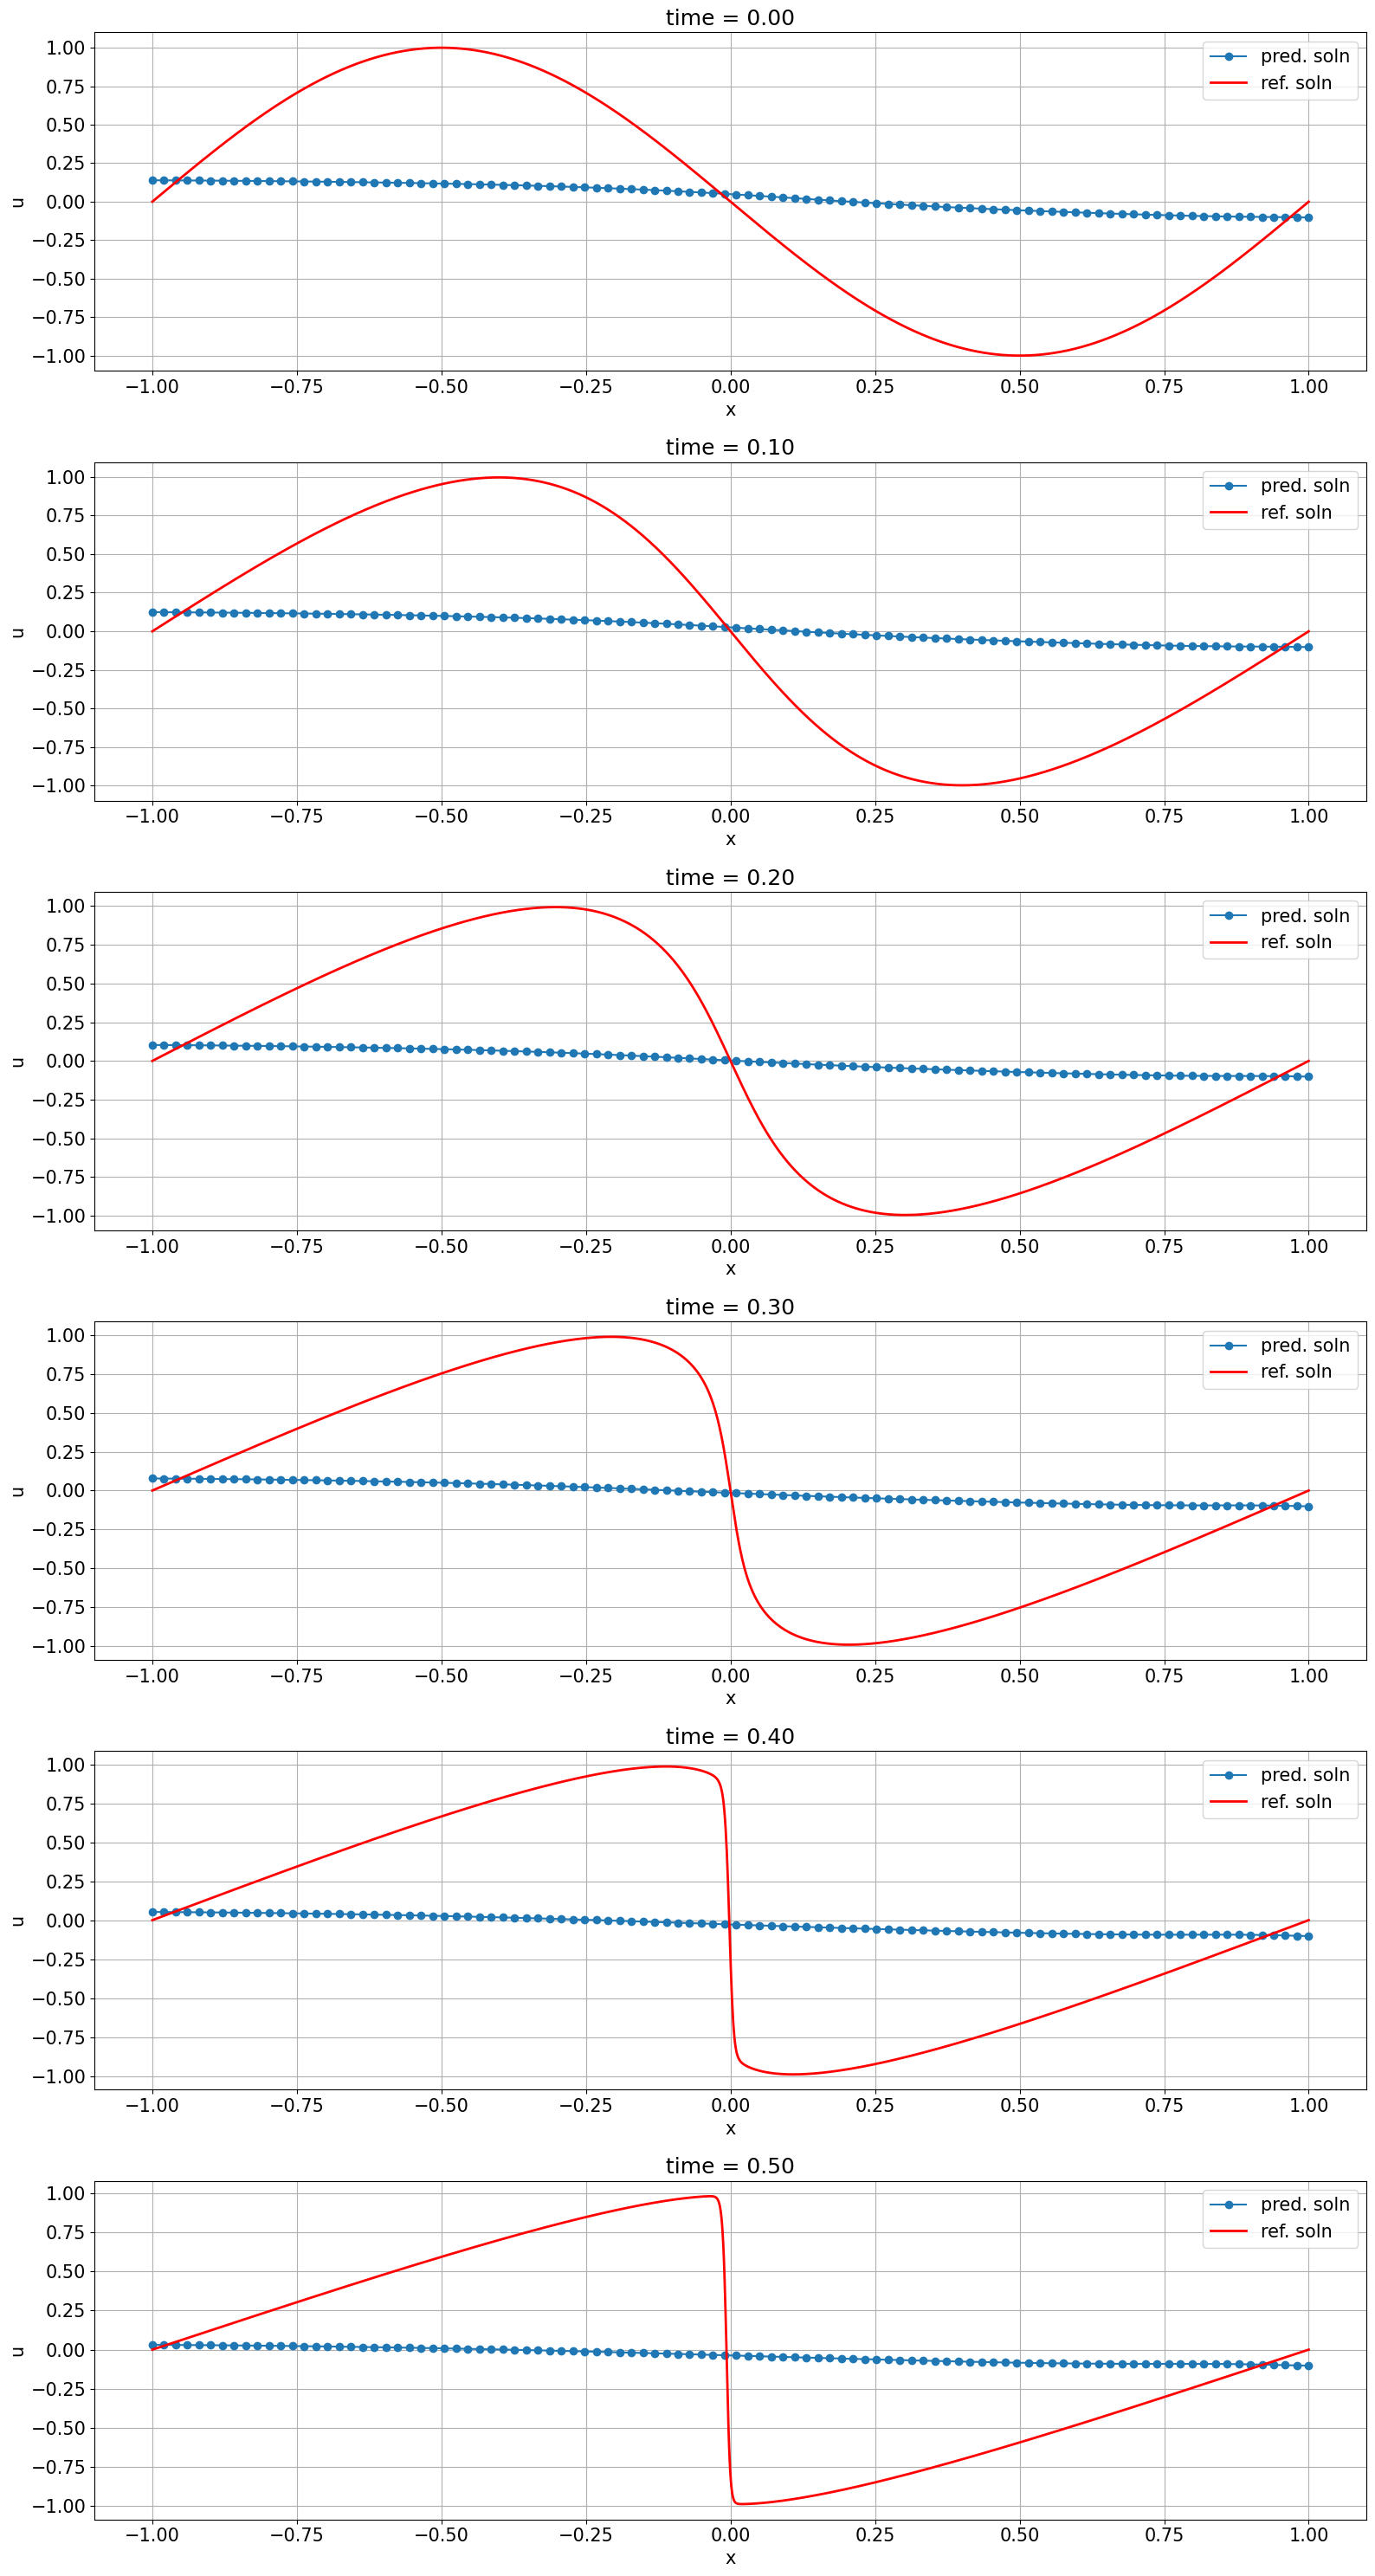

In [11]:
model = KAN(width=[2, 10, 10, 5, 5,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

steps = 20
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

interior pde loss: 5.10e-01 | bc loss: 5.77e-03 | ic loss: 3.27e-01 : 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Training completed in 24.25 seconds.


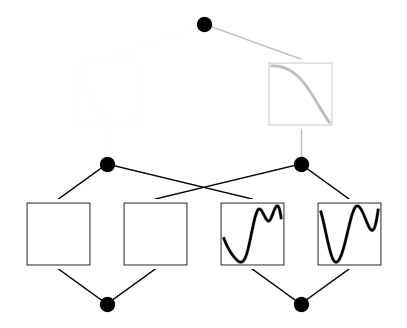

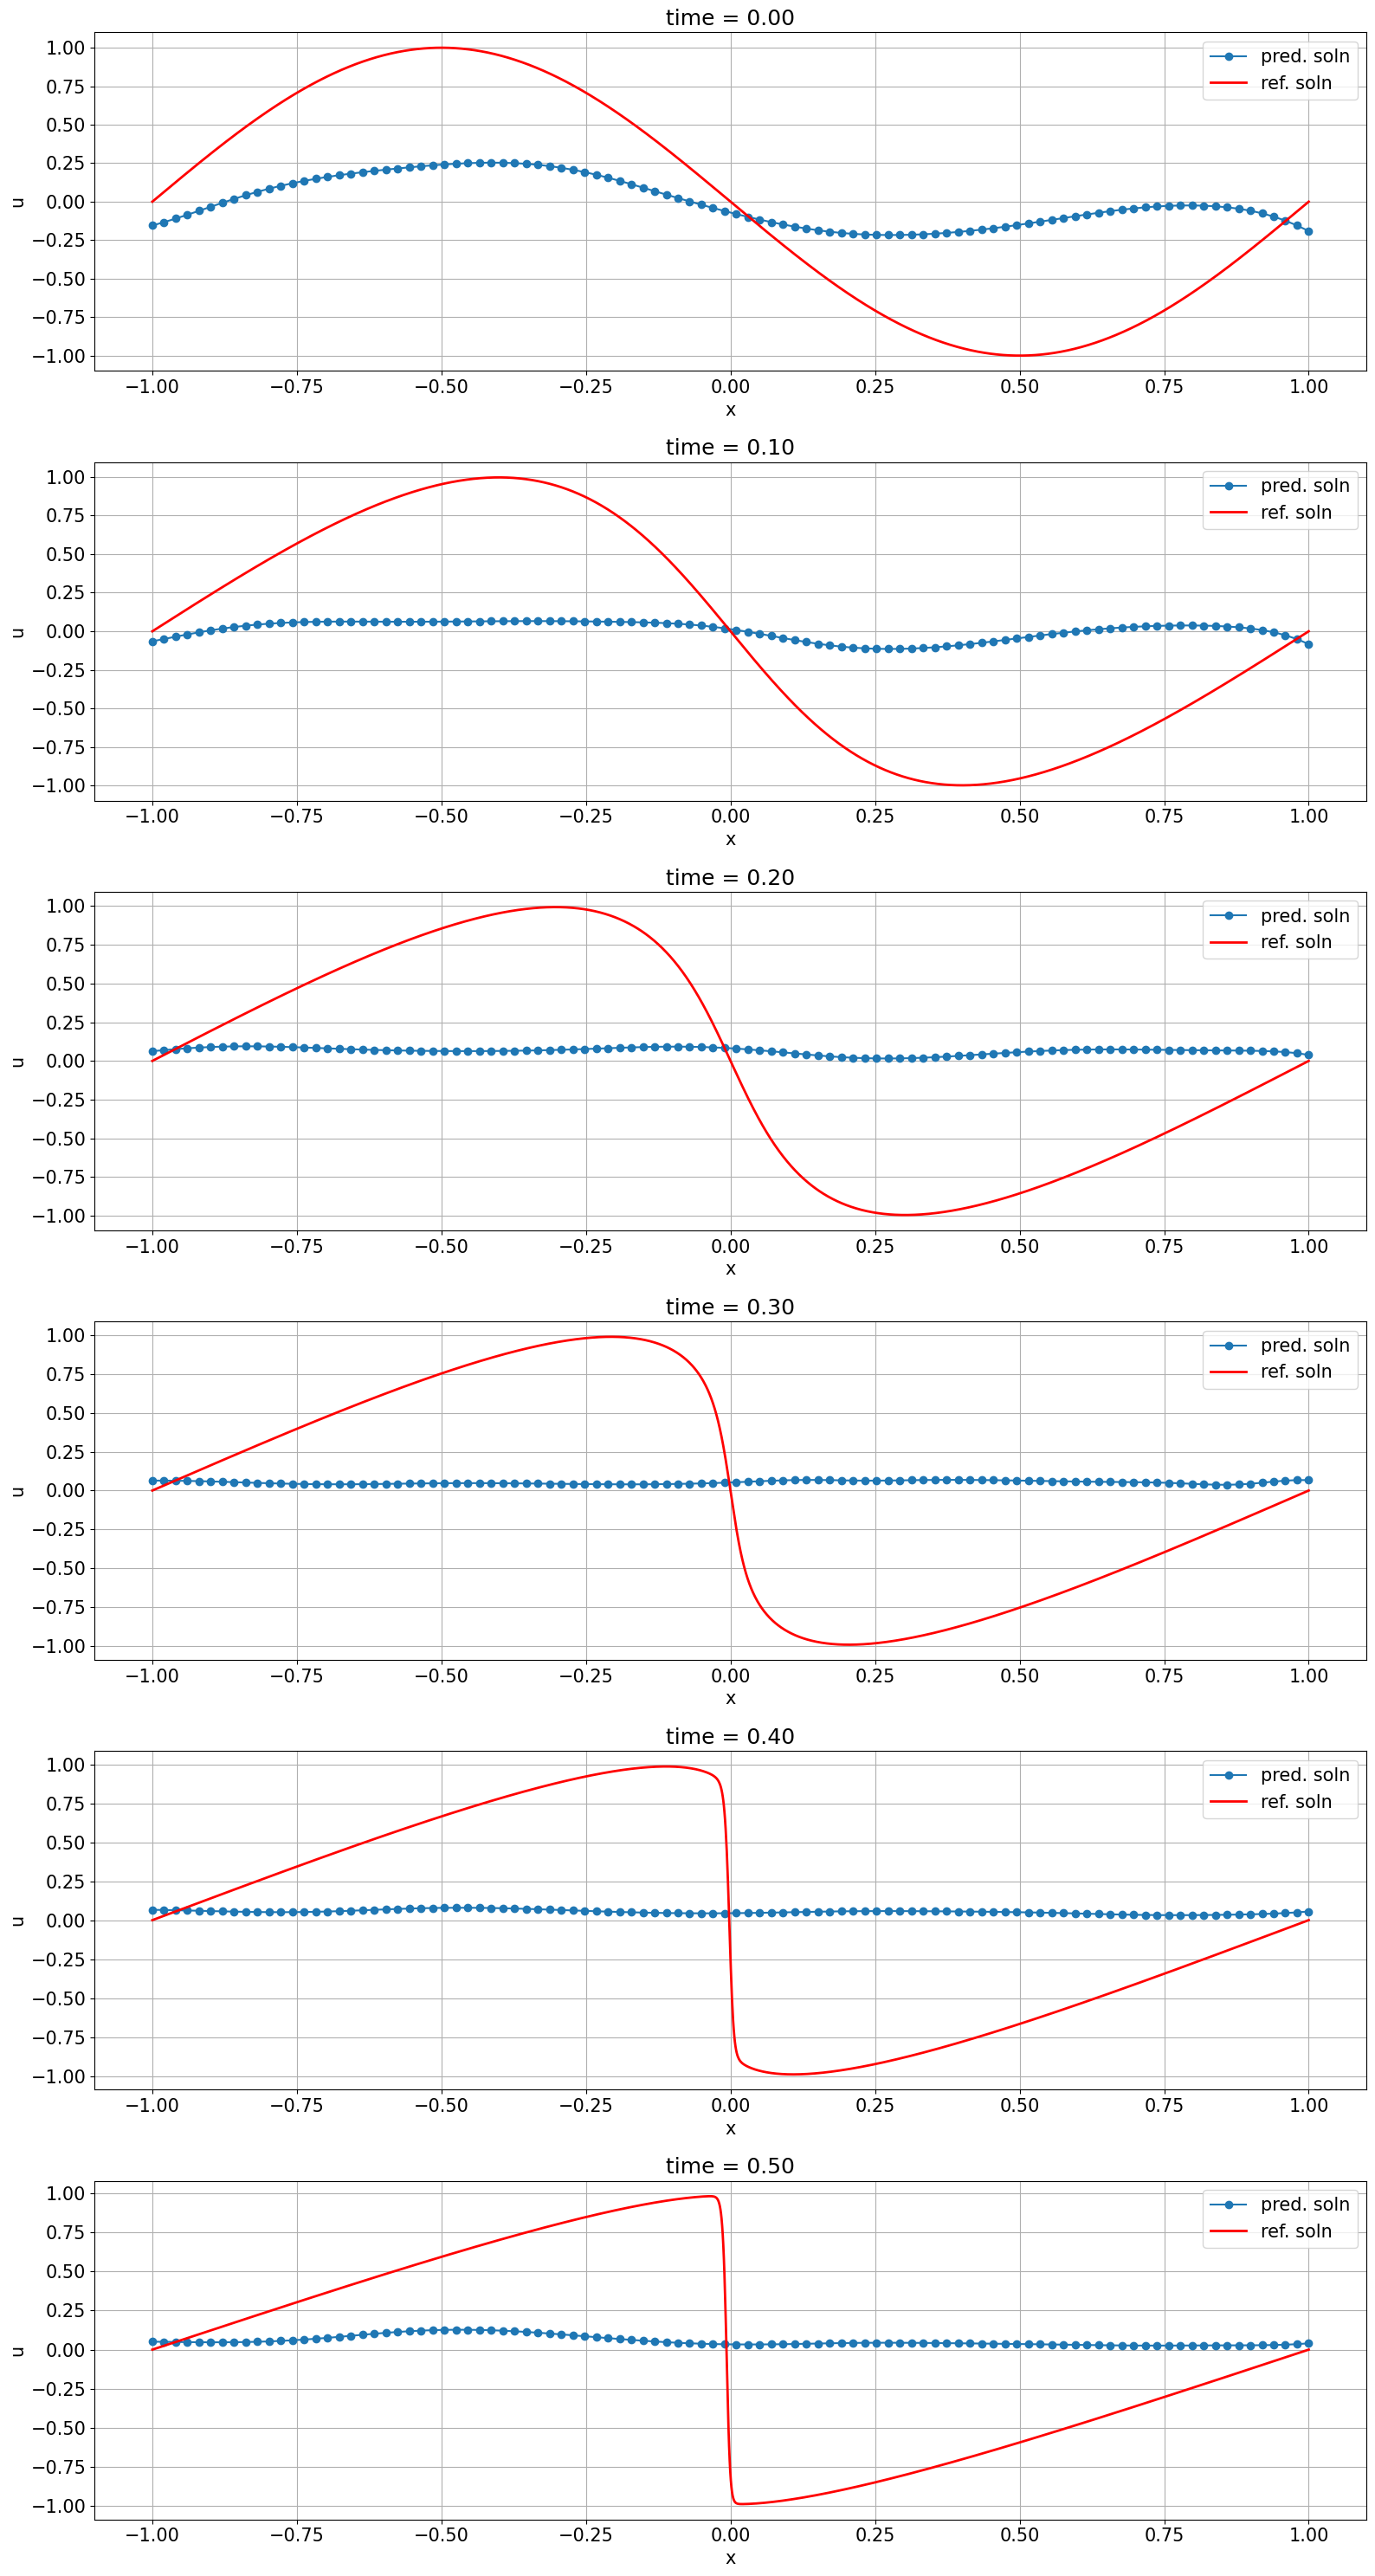

In [16]:
model = KAN(width=[2, 2,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
# optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
optimizer = torch.optim.Adam(model.parameters(), lr=1, weight_decay=1e-7)

steps = 100
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')